# Predcition of Hospital Admission Related to Pneumonia

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to pneumonia.

In [1]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.preprocessing import OneHotEncoder
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [2]:
# def create_lineplot(data, var, title, legend_title, ax1):
def create_lineplot(data, var, title, ax1):
    a = data.groupby(['date', var]).size().reset_index()
    a.columns = ['date', var, 'Freq']
    # a.Freq = a.Freq*1000
    a = a[a.Freq > 5]
    sns.lineplot(x='date', y='Freq', 
            hue=var, 
            data=a,
            ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('Count')
    ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
#     ax1.legend(title=legend_title)
    # ax1.grid()
    ax1.axvline(x="2020-01", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2020-04", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2021-04", color='black', ls='--', lw=1.5)

In [3]:
# function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [4]:
def round_five_mul(x, base=5):
    return base * round(x/base)

In [5]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking_status', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'pneumonia_date_'+str(i), 'pneumonia_ab_date_'+str(i), 'pneumonia_ab_type_'+str(i),
                   'incdt_pneumonia_date_'+str(i), 'admitted_pneumonia_date_'+str(i), 'sgss_gp_cov_pneumonia_date_'+str(i)]]
    
    #drop rows with no pneumonia reord
    datum = datum[datum['pneumonia_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with pneumonia_i
    datum = datum[datum['sgss_gp_cov_pneumonia_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'pneumonia_date_'+str(i): 'pneumonia_date', 'pneumonia_ab_date_'+str(i): 'pneumonia_ab_date', 
                           'pneumonia_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_pneumonia_date_'+str(i): 'incdt_pneumonia_date', 'incdt_pneumonia_type_'+str(i): 'incdt_pneumonia_type',
                           'admitted_pneumonia_date_'+str(i): 'admitted_pneumonia_date',
                           'sgss_gp_cov_pneumonia_date_'+str(i): 'sgss_gp_cov_pneumonia_date'},
                inplace=True)
    
    return datum

In [6]:
def cox_data_prep(data, vars, vars_countinuous, vars_output):
    # data_req = data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit',
    #              'event_pneumonia_admitted', 'duration_pneumonia_admitted']]
    data_req = data[vars+vars_countinuous+vars_output]

    # encoding categorical data for CPH
    # data_enc = data_req[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit']].reset_index()
    data_enc = data_req[vars+vars_countinuous].reset_index()
    # data_enc

    # creating instance of one-hot-encoder
    enc = OneHotEncoder()
    results = enc.fit_transform(data_enc)
    data_req_enc = pd.DataFrame(enc.fit_transform(data_enc[vars]).toarray())
    data_req_enc.columns = enc.get_feature_names(data_enc[vars].columns)
    data_req_enc = data_enc[vars_countinuous].join(data_req_enc) 

    return data_req, data_req_enc

In [7]:
def make_summary_table(infection, infection_type, data):
    #summary table
    summary_table = data.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = data.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = data.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'
    # summary_table

    # save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [8]:
def make_summary_table_hosped(infection, infection_type, data):
    #keep hospitalised cses (events=1)
    data_hosped = data[data['event_'+infection+'_admitted'] == 1]

    # encoding categorical hosped data
    data_hosped = data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period', 'antibacterial_brit']].reset_index()
    # data_hosped

    # creating instance of one-hot-encoder
    enc = OneHotEncoder()
    results = enc.fit_transform(data_hosped)
    data_hosped_enc = pd.DataFrame(enc.fit_transform(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']]).toarray())
    data_hosped_enc.columns = enc.get_feature_names(data_hosped[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period']].columns)
    data_hosped_enc = data_hosped[['antibacterial_brit']].join(data_hosped_enc)

    # data_hosped_enc#.head()
    #summary table for hosped cases
    summary_table_hosped = data_hosped_enc.sum(axis=0).reset_index()
    summary_table_hosped.columns = ['variable', 'count']
    summary_table_hosped['mean'] = data_hosped_enc.mean(axis=0).reset_index()[0]
    #round count to make last digit either 0 or 5
    summary_table_hosped['count'] = round_five_mul(summary_table_hosped['count'], base=5)
    summary_table_hosped['std'] = data_hosped_enc.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table_hosped.loc[(summary_table_hosped['count'] <= 5), 'count'] = 'SM'
    # summary_table_hosped

    # save table
    summary_table_hosped.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'_hosped.csv', index=False)

In [9]:
def cox_model_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    return cph, data_train, data_test

In [10]:
def betas_sumbetas_calculate(cph, directory, betas_name, data_infection_enc, data_infection, sum_betas_name):
    # cleaning up covariates to make them compatible with the encoded data
    covariates = cph.params_.reset_index()#.hazard_ratios_
    covariates.covariate = covariates.covariate.str.replace("[","")
    covariates.covariate = covariates.covariate.str.replace("]","")
    covariates.covariate = covariates.covariate.str.replace("T.","_")
    # covariates.shape

    # save coefficients
    covariates.to_csv(directory+betas_name, index=False)

    # transpose and sort covariates and coefficients
    covariatesT = covariates.T
    # covariatesT.covariate = covariates
    header = covariatesT.iloc[0]
    covariatesT = covariatesT[1:]
    covariatesT.columns = header
    covariatesT = covariatesT.sort_index(axis = 1) #sort covariates to match data
    # covariatesT.shape

    # further cleaning up covariates to make them compatible with the encoded data
    mylist = ["'" + item + "'" for item in covariates.covariate] #adds single quotation mark
    mylist = [value.replace("'", "") for value in mylist] #removes double quotation mark 

    #match mylist (covariates of cox model) with encoded data
    data = data_infection_enc[data_infection_enc.columns.intersection(mylist)] 
    data = data.sort_index(axis = 1) #sort 
    # data.shape

    # multiply betas and encoded data
    betas = data.multiply(np.array(covariatesT), axis='columns')
    # betas

    # sum up betas of each row to calculate sum of betas 
    sum_betas = betas.sum(axis=1)
    # sum_betas
#######################################################
    # predict cumulative hazard values at day 30 and match them with sum of betas
    sum_betas_hazard = cph.predict_cumulative_hazard(data_infection).loc[[30]].T.reset_index(drop=True)
    sum_betas_hazard['sum_betas'] = sum_betas
    # sum_betas_hazard

    #drop rows with predicted risks greater than 99th percentile of all risks
    sum_betas_hazard = sum_betas_hazard[sum_betas_hazard[30] <= sum_betas_hazard[30].quantile(0.99)]  
    # return sum_betas_hazard

    # sort values of sum of betas
    sum_betas_hazard = sum_betas_hazard.sort_values(by=['sum_betas'])
    # sum_betas_hazard

    # binning sum of betas into 100 bins
    sum_betas_hazard['bins'] = pd.cut(sum_betas_hazard['sum_betas'], 100) #100 intervals between min and max of sum_betas
    # sum_betas_hazard

    #calculate mean of cumulative hazar at day 30 by groupby 
    sum_betas_hazard_groupby = sum_betas_hazard.groupby(['bins'])[30.0].describe().reset_index()
    # sum_betas_hazard_groupby

    #calculate interpolation of missing mean values 
    sum_betas_hazard_groupby['mean_interpolate'] = sum_betas_hazard_groupby['mean'].interpolate(method='linear')

    # separate upper and lower boundries of bins
    sum_betas_hazard_groupby['bin_lower'] = sum_betas_hazard_groupby['bins'].map(attrgetter('left'))
    sum_betas_hazard_groupby['bin_upper'] = sum_betas_hazard_groupby['bins'].map(attrgetter('right'))
    # sum_betas_hazard_groupby.head()

    # select relevant columns including mean of cumulative hazard for each bin and the interpolation of means of cumulative hazard
    sum_betas = sum_betas_hazard_groupby[['bin_lower', 'bin_upper', 'mean_interpolate']]

    # save relevant columns of sum_betas
    sum_betas.to_csv(directory+sum_betas_name, index=False)

In [11]:
def cph_roc_curve(cph, event_col_name, data_train, data_test, directory, roc_name):
    # analysis of discrimination (training) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_train_cumulative_hazard = cph.predict_cumulative_hazard(data_train)
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.loc[[30]].T
    cph_train_cumulative_hazard[event_col_name] = data_train[event_col_name]
    cph_train_cumulative_hazard = cph_train_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
    # cph_train_cumulative_hazard

    # analysis of discrimination (testing) by calculating cumulative hazard at day 30 and comparing it with variable event  
    cph_test_cumulative_hazard = cph.predict_cumulative_hazard(data_test)
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.loc[[30]].T
    cph_test_cumulative_hazard[event_col_name] = data_test[event_col_name]
    cph_test_cumulative_hazard = cph_test_cumulative_hazard.rename(columns={30: 'cumulative_hazard'}, inplace=False)
    # cph_test_cumulative_hazard

    # plot roc curves
    r_fpr1, r_tpr1, _ = roc_curve(cph_train_cumulative_hazard[event_col_name], cph_train_cumulative_hazard.cumulative_hazard)
    r_fpr2, r_tpr2, _ = roc_curve(cph_test_cumulative_hazard[event_col_name], cph_test_cumulative_hazard.cumulative_hazard)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line1, = plt.plot(r_fpr1, r_tpr1, linestyle='-', marker='o', markersize=6, markevery=0.1, color='black', label='Cox with development data')
    line2, = plt.plot(r_fpr2, r_tpr2, linestyle='--', marker='v', markersize=6, markevery=0.1, color='red', label='Cox with validation data')

    squares = [0,1.01]
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)

    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=14)
    # plt.title('', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    # plt.tight_layout()
    plt.savefig(directory+'/'+roc_name, bbox_inches='tight')
    plt.show()

In [12]:
def cph_calibration(cph, data_train, event_name, data_test, directory, calib_train_name, calib_test_name):
    #predict cumulative hazard in day 30
    prob_pred_true_train = cph.predict_cumulative_hazard(data_train).loc[[30]].T
    prob_pred_true_train.columns = ['pred']
    # prob_pred_true_train

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_train['bins'] = pd.qcut(prob_pred_true_train['pred'], 10)
    # prob_pred_true_train

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_train = pd.merge(prob_pred_true_train, data_train[event_name], left_index=True, right_index=True)
    # prob_pred_true_train

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_train_groupby_bin = prob_pred_true_train.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_train_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']
    # prob_pred_true_train_groupby_bin

    #calculate proportion of events in each bin
    prob_pred_true_train_groupby_bin['event_proportion'] = prob_pred_true_train_groupby_bin['event_sum']/prob_pred_true_train_groupby_bin['event_count']
    # prob_pred_true_train_groupby_bin
############
    #predict cumulative hazard in day 30
    prob_pred_true_test = cph.predict_cumulative_hazard(data_test).loc[[30]].T #[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'antibacterial_brit', 'gp_count']]).loc[[30]].T#.reset_index(drop=True)
    prob_pred_true_test.columns = ['pred']

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred_true_test['bins'] = pd.qcut(prob_pred_true_test['pred'], 10)

    #merge cumulative hazards with their actual events (0, 1)
    prob_pred_true_test = pd.merge(prob_pred_true_test, data_test[event_name], left_index=True, right_index=True)

    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    prob_pred_true_test_groupby_bin = prob_pred_true_test.groupby('bins')[['pred', event_name]].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_true_test_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'event_mean', 'event_sum', 'event_count']

    #calculate proportion of events in each bin
    prob_pred_true_test_groupby_bin['event_proportion'] = prob_pred_true_test_groupby_bin['event_sum']/prob_pred_true_test_groupby_bin['event_count']
    # prob_pred_true_test_groupby_bin
###################
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_train_groupby_bin.pred_mean, prob_pred_true_train_groupby_bin.event_proportion, marker='o', facecolors='none', edgecolors='g', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_train_groupby_bin.pred_mean.max(), prob_pred_true_train_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    # plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_train_name, bbox_inches='tight')
    plt.show()

    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.scatter(prob_pred_true_test_groupby_bin.pred_mean, prob_pred_true_test_groupby_bin.event_proportion, marker='v', facecolors='none', edgecolors='y', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    plt.ylim(0, max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2) + (max(prob_pred_true_test_groupby_bin.pred_mean.max(), prob_pred_true_test_groupby_bin.event_proportion.max()).round(decimals = 2)/3))
    # plt.legend(['CPH calibration with training data', 'CPH calibration with testing data'], fontsize=14)
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.savefig(directory+calib_test_name, bbox_inches='tight')
    plt.show()

In [13]:
def cph_output(cph, infection, infection_type, data_train, data_test, event_name, duration_name, directory):
    # calculate concordance index, AUROC, and Brier score of cph model
    concord_index_train = concordance_index(data_train[duration_name], -cph.predict_partial_hazard(data_train), data_train[event_name])
    concord_index_test = concordance_index(data_test[duration_name], -cph.predict_partial_hazard(data_test), data_test[event_name])
    
    # save model outputs
    a = open(directory+'cph_'+infection+'_'+infection_type+'_output.txt', "w")
    a.write("")
    a.writelines(['Concordance index for '+infection+'_'+infection_type+' with development data: %.4f' % (concord_index_train), 
                '\nConcordance index for '+infection+'_'+infection_type+' with validation data: %.4f' % (concord_index_test)])

In [14]:
def cox_model_abs_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + pneumonia_ab_date"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    return cph, data_train, data_test

In [15]:
def cox_model_ab_type_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + ab_type_cat"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    return cph, data_train, data_test

In [16]:
def cox_model_strat_sex_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="age_cat + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + pneumonia_ab_date"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    return cph, data_train, data_test

In [17]:
def cox_model_strat_age_build(infection, infection_type, data):#, vars, vars_continuous):
    #randomly splitting data into training (%75) and testing (%25)
    data_train, data_test = train_test_split(data, test_size=0.25, random_state=42)

    # vars_all = vars + vars_continuous

    cph = CoxPHFitter()
    cph.fit(data_train,
            duration_col='duration_'+infection+'_admitted',
            event_col='event_'+infection+'_admitted',
            formula="sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking_status + season + bmi_cat + antibacterial_brit + pneumonia_ab_date"
            )
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    return cph, data_train, data_test

## 1- data preparation

In [18]:
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_pneumonia.csv.gz')

data.shape

(200000, 224)

In [19]:
# save model outputs
a = open("../output/hospitalisation_prediction_pneumonia/data_pneumonia_record_cph_pneumonia.txt", "w")
a.write("")
a.writelines(['data_pneumonia_1 #with a record, #with no record: %.0f' % (data['pneumonia_date_1'].notna().sum()), ', %.0f' % (data['pneumonia_date_1'].isna().sum()),
              '\ndata_pneumonia_2 #with a record, #with no record: %.0f' % (data['pneumonia_date_2'].notna().sum()), ', %.0f' % (data['pneumonia_date_2'].isna().sum()),
              '\ndata_pneumonia_3 #with a record, #with no record: %.0f' % (data['pneumonia_date_3'].notna().sum()), ', %.0f' % (data['pneumonia_date_3'].isna().sum()),
              '\ndata_pneumonia_4 #with a record, #with no record: %.0f' % (data['pneumonia_date_4'].notna().sum()), ', %.0f' % (data['pneumonia_date_4'].isna().sum()),
              '\ndata_pneumonia_5 #with a record, #with no record: %.0f' % (data['pneumonia_date_5'].notna().sum()), ', %.0f' % (data['pneumonia_date_5'].isna().sum()),
              '\ndata_pneumonia_6 #with a record, #with no record: %.0f' % (data['pneumonia_date_6'].notna().sum()), ', %.0f' % (data['pneumonia_date_6'].isna().sum()),
              '\ndata_pneumonia_7 #with a record, #with no record: %.0f' % (data['pneumonia_date_7'].notna().sum()), ', %.0f' % (data['pneumonia_date_7'].isna().sum()),
              '\ndata_pneumonia_8 #with a record, #with no record: %.0f' % (data['pneumonia_date_8'].notna().sum()), ', %.0f' % (data['pneumonia_date_8'].isna().sum()),
              '\ndata_pneumonia_9 #with a record, #with no record: %.0f' % (data['pneumonia_date_9'].notna().sum()), ', %.0f' % (data['pneumonia_date_9'].isna().sum()),
              '\ndata_pneumonia_10 #with a record, #with no record: %.0f' % (data['pneumonia_date_10'].notna().sum()), ', %.0f' % (data['pneumonia_date_10'].isna().sum()),
              '\ndata_pneumonia_11 #with a record, #with no record: %.0f' % (data['pneumonia_date_11'].notna().sum()), ', %.0f' % (data['pneumonia_date_11'].isna().sum()),
              '\ndata_pneumonia_12 #with a record, #with no record: %.0f' % (data['pneumonia_date_12'].notna().sum()), ', %.0f' % (data['pneumonia_date_12'].isna().sum()),
              '\ndata_pneumonia_13 #with a record, #with no record: %.0f' % (data['pneumonia_date_13'].notna().sum()), ', %.0f' % (data['pneumonia_date_13'].isna().sum()),
              '\ndata_pneumonia_14 #with a record, #with no record: %.0f' % (data['pneumonia_date_14'].notna().sum()), ', %.0f' % (data['pneumonia_date_14'].isna().sum()),
              '\ndata_pneumonia_15 #with a record, #with no record: %.0f' % (data['pneumonia_date_15'].notna().sum()), ', %.0f' % (data['pneumonia_date_15'].isna().sum()),
              '\ndata_pneumonia_16 #with a record, #with no record: %.0f' % (data['pneumonia_date_16'].notna().sum()), ', %.0f' % (data['pneumonia_date_16'].isna().sum()),
              '\ndata_pneumonia_17 #with a record, #with no record: %.0f' % (data['pneumonia_date_17'].notna().sum()), ', %.0f' % (data['pneumonia_date_17'].isna().sum()),
              '\ndata_pneumonia_18 #with a record, #with no record: %.0f' % (data['pneumonia_date_18'].notna().sum()), ', %.0f' % (data['pneumonia_date_18'].isna().sum()),
              '\ndata_pneumonia_19 #with a record, #with no record: %.0f' % (data['pneumonia_date_19'].notna().sum()), ', %.0f' % (data['pneumonia_date_19'].isna().sum()),
              '\ndata_pneumonia_20 #with a record, #with no record: %.0f' % (data['pneumonia_date_20'].notna().sum()), ', %.0f' % (data['pneumonia_date_20'].isna().sum()),
              ])

### 1-2- additional variables
Calculating Charlson Comorbidity Index based on https://www.nature.com/articles/4500889.pdf?origin=ppub

In [20]:
data['CCI'] = np.nan
col0 = data.columns.get_loc('CCI')

col1 = data.columns.get_loc('cancer_comor')
col2 = data.columns.get_loc('cardiovascular_comor')
col3 = data.columns.get_loc('chronic_obstructive_pulmonary_comor') ##
col4 = data.columns.get_loc('heart_failure_comor') ##
col5 = data.columns.get_loc('connective_tissue_comor')
col6 = data.columns.get_loc('dementia_comor')
col7 = data.columns.get_loc('diabetes_comor')
col8 = data.columns.get_loc('diabetes_complications_comor')
col9 = data.columns.get_loc('hemiplegia_comor')
col10 = data.columns.get_loc('hiv_comor')
col11 = data.columns.get_loc('metastatic_cancer_comor')
col12 = data.columns.get_loc('mild_liver_comor')
col13 = data.columns.get_loc('mod_severe_liver_comor')
col14 = data.columns.get_loc('mod_severe_renal_comor')
col15 = data.columns.get_loc('mi_comor')
col16 = data.columns.get_loc('peptic_ulcer_comor')
col17 = data.columns.get_loc('peripheral_vascular_comor')


for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, col15] == 1: # mi_comor
        n=n+1
    if data.iat[idx, col2] == 1: # cardiovascular_comor
        n=n+1 
    if data.iat[idx, col17] == 1: # peripheral_vascular_comor
        n=n+1 
    if data.iat[idx, col3] == 1: # chronic_obstructive_pulmonary_comor
        n=n+1
    if data.iat[idx, col7] == 1: # diabetes_comor
        n=n+1
    if data.iat[idx, col6] == 1: # dementia_comor
        n=n+1
    if data.iat[idx, col16] == 1: # peptic_ulcer_comor
        n=n+1
    if data.iat[idx, col5] == 1: # connective_tissue_comor
        n=n+1
    if data.iat[idx, col12] == 1: # mild_liver_comor
        n=n+1
    if data.iat[idx, col9] == 1: # hemiplegia_comor
        n=n+2
    if data.iat[idx, col14] == 1: # mod_severe_renal_comor
        n=n+2
    if data.iat[idx, col8] == 1: # diabetes_complications_comor
        n=n+2
    if data.iat[idx, col1] == 1: # cancer_comor
        n=n+2
    if data.iat[idx, col13] == 1: # mod_severe_liver_comor
        n=n+3
    if data.iat[idx, col11] == 1: # metastatic_cancer_comor
        n=n+6
    if data.iat[idx, col10] == 1: # hiv_comor
        n=n+6
    
    data.iat[idx, col0]=n

data.CCI.value_counts()

1.0     37132
0.0     37089
2.0     32860
3.0     24755
4.0     14902
6.0     12315
7.0     10096
5.0      8411
8.0      7835
9.0      5890
10.0     3386
11.0     1810
12.0     1351
13.0      861
14.0      558
15.0      349
16.0      200
17.0      109
18.0       57
19.0       22
20.0        6
22.0        3
21.0        3
Name: CCI, dtype: int64

## 2- data preparation
This includes data type conversion and exclusion of cases that are not considered in the infection-related hospital admission, i.e. those who were diagnosed with Covid19 three months (=90 days) before and one month (=30 days) after hospital admission.

### 2-1- gathering data

In [21]:
#read 20 pneumonias and concatenate them 
data_pneumonia_1 = proc_infec_data(data,1)
data_pneumonia_2 = proc_infec_data(data,2)
data_pneumonia_3 = proc_infec_data(data,3)
data_pneumonia_4 = proc_infec_data(data,4)
data_pneumonia_5 = proc_infec_data(data,5)
data_pneumonia_6 = proc_infec_data(data,6)
data_pneumonia_7 = proc_infec_data(data,7)
data_pneumonia_8 = proc_infec_data(data,8)
data_pneumonia_9 = proc_infec_data(data,9)
data_pneumonia_10 = proc_infec_data(data,10)
data_pneumonia_11 = proc_infec_data(data,11)
data_pneumonia_12 = proc_infec_data(data,12)
data_pneumonia_13 = proc_infec_data(data,13)
data_pneumonia_14 = proc_infec_data(data,14)
data_pneumonia_15 = proc_infec_data(data,15)
data_pneumonia_16 = proc_infec_data(data,16)
data_pneumonia_17 = proc_infec_data(data,17)
data_pneumonia_18 = proc_infec_data(data,18)
data_pneumonia_19 = proc_infec_data(data,19)
data_pneumonia_20 = proc_infec_data(data,20)

data_pneumonia = pd.concat([data_pneumonia_1, data_pneumonia_2, data_pneumonia_3, data_pneumonia_4, data_pneumonia_5, data_pneumonia_6, data_pneumonia_7, data_pneumonia_8, data_pneumonia_9, data_pneumonia_10, data_pneumonia_11, data_pneumonia_12, data_pneumonia_13, data_pneumonia_14, data_pneumonia_15, data_pneumonia_16, data_pneumonia_17, data_pneumonia_18, data_pneumonia_19, data_pneumonia_20])
data_pneumonia.reset_index(inplace=True, drop=True)
data_pneumonia.shape

(216036, 20)

### 2-2- add season, event, and duration variables
#### season

In [22]:
# convert data types
data_pneumonia['pneumonia_date'] = data_pneumonia['pneumonia_date'].astype('datetime64[ns]')
data_pneumonia['admitted_pneumonia_date'] = data_pneumonia['admitted_pneumonia_date'].astype('datetime64[ns]')
data_pneumonia.died_date = data_pneumonia.died_date.astype('datetime64[ns]')
data_pneumonia.deregistered_date = data_pneumonia.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_pneumonia['date'] = data_pneumonia['pneumonia_date'] #gp_cons_pneumonia
data_pneumonia['date'] = data_pneumonia['date'].dt.strftime('%Y-%m')
print(f'min date: {data_pneumonia.date.min()}')
print(f'max date: {data_pneumonia.date.max()}')
print(f'length of data_pneumonia: {len(data_pneumonia)}')

min date: 2019-01
max date: 2022-11
length of data_pneumonia: 216036


In [23]:
#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')
# today_date_y_m

#drop any records of data_pneumonia with today's date in year and month
data_pneumonia = data_pneumonia[data_pneumonia['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_pneumonia = data_pneumonia[data_pneumonia['date'] != last_1_month_date_y_m]
data_pneumonia = data_pneumonia[data_pneumonia['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of pneumonia records
data_pneumonia['season'] = np.nan
data_pneumonia['date_month'] = pd.DatetimeIndex(data_pneumonia['date']).month

conditions = [
    (data_pneumonia['date_month'] >= 3) & (data_pneumonia['date_month'] <= 5),
    (data_pneumonia['date_month'] >= 6) & (data_pneumonia['date_month'] <= 8),
    (data_pneumonia['date_month'] >= 9) & (data_pneumonia['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_pneumonia['season'] = np.select(conditions, choices, default='winter')

print(data_pneumonia['season'].value_counts())
print(f'\nmin date: {data_pneumonia.date.min()}')
print(f'max date: {data_pneumonia.date.max()}')
print(f'length: {len(data_pneumonia)}')

summer    56689
spring    55947
winter    49755
autumn    41763
Name: season, dtype: int64

min date: 2019-01
max date: 2022-08
length: 204154


In [24]:
# data_pneumonia = data_pneumonia[data_pneumonia['date'] <= '2019-12']
# data_pneumonia = data_pneumonia[(data_pneumonia['date'] >= '2020-03') & (data_pneumonia['date']<= '2021-03')]
# data_pneumonia = data_pneumonia[data_pneumonia['date'] >= '2021-04']
# print(f'min date: {data_pneumonia.date.min()}')
# print(f'max date: {data_pneumonia.date.max()}')

In [ ]:
#add period variable
data_pneumonia.loc[(data_pneumonia['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_pneumonia.loc[((data_pneumonia['date'] >= '2020-01') & (data_pneumonia['date'] <= '2021-03')), 'period'] = 'during_pandemic'
data_pneumonia.loc[(data_pneumonia['date'] >= '2021-04'), 'period'] = 'post_2nd_lockdown'

#### event and duration

In [25]:
#scenario 1
#not hosped (nothing happened)
#data_pneumonia = data_pneumonia[data_pneumonia['admitted_pneumonia_date'].notnull()]
data_pneumonia.loc[data_pneumonia['admitted_pneumonia_date'].isnull(), 'event_pneumonia_admitted'] = 0
data_pneumonia['event_pneumonia_admitted'].value_counts()

0.0    142768
Name: event_pneumonia_admitted, dtype: int64

In [26]:
#scenario 2 
# become a case (uncensoring)
#calculating days between infection gp consultation and hosp
# data_pneumonia['delta_pneumonia_admitted'] = (data_pneumonia['admitted_pneumonia_date'] - data_pneumonia['pneumonia_date']).dt.days
data_pneumonia['delta_pneumonia_admitted'] = (data_pneumonia['admitted_pneumonia_date'] - data_pneumonia['pneumonia_date']).dt.days #gp_cons_pneumonia
data_pneumonia.loc[((data_pneumonia['delta_pneumonia_admitted'] >= 0) & (data_pneumonia['delta_pneumonia_admitted'] <= 30)), 'event_pneumonia_admitted'] = 1
# data_pneumonia['event_pneumonia_admitted'].value_counts()

#scenario 2
#drop whoever was admitted before pneumonia consultation, i.e. negative value for delta_pneumonia_admitted
data_pneumonia = data_pneumonia[~(data_pneumonia['delta_pneumonia_admitted'] < 0)]
data_pneumonia['delta_pneumonia_admitted'].value_counts()

39.0      61
57.0      60
94.0      55
19.0      55
145.0     55
          ..
1396.0     1
1379.0     1
1295.0     1
1403.0     1
1281.0     1
Name: delta_pneumonia_admitted, Length: 1383, dtype: int64

In [27]:
#scenario 3
#censor died patients
data_pneumonia['delta_admitted_died'] = (data_pneumonia['died_date'] - data_pneumonia['admitted_pneumonia_date']).dt.days
data_pneumonia.loc[data_pneumonia['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
# data_pneumonia.loc[data_pneumonia['delta_admitted_died'] >= 0, 'event_pneumonia_admitted'] = 0
data_pneumonia.loc[((data_pneumonia['delta_admitted_died'] >= 0) & (data_pneumonia['delta_admitted_died'] <= 30)), 'event_pneumonia_admitted'] = 0
# data_pneumonia['event_pneumonia_admitted'].value_counts()

#scenario 3
#censor deregistered patients
data_pneumonia['delta_admitted_deregistered'] = (data_pneumonia['deregistered_date'] - data_pneumonia['admitted_pneumonia_date']).dt.days
data_pneumonia.loc[data_pneumonia['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
# data_pneumonia.loc[data_pneumonia['delta_admitted_deregistered'] >= 0, 'event_pneumonia_admitted'] = 0
data_pneumonia.loc[((data_pneumonia['delta_admitted_deregistered'] > 0) & (data_pneumonia['delta_admitted_deregistered'] <= 30)), 'event_pneumonia_admitted'] = 0
# data_pneumonia['event_pneumonia_admitted'].value_counts()

#agg scenario 3s
data_pneumonia['delta_admitted_died_deregistered'] = data_pneumonia['delta_admitted_deregistered'].combine_first(data_pneumonia['delta_admitted_died'])
data_pneumonia.loc[data_pneumonia['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN
data_pneumonia['delta_admitted_died_deregistered'].isnull().sum()#.value_counts()

171898

In [28]:
#scenario 1
#any other patients (nothing happened)
data_pneumonia['event_pneumonia_admitted'] = data_pneumonia['event_pneumonia_admitted'].replace(np.NaN, 0)
data_pneumonia['event_pneumonia_admitted'].value_counts()

0.0    173721
1.0      1279
Name: event_pneumonia_admitted, dtype: int64

In [29]:
#assign values for duration column
data_pneumonia['duration_pneumonia_admitted'] = data_pneumonia['delta_pneumonia_admitted'].combine_first(data_pneumonia['delta_admitted_died_deregistered'])
data_pneumonia['duration_pneumonia_admitted'] = data_pneumonia['duration_pneumonia_admitted'].replace(np.NaN, 30)
data_pneumonia.loc[(data_pneumonia['duration_pneumonia_admitted'] > 30), 'duration_pneumonia_admitted'] = 30
data_pneumonia['duration_pneumonia_admitted'].value_counts()

30.0    173765
19.0        55
10.0        54
6.0         53
15.0        50
8.0         48
21.0        48
18.0        47
2.0         45
9.0         45
1.0         44
0.0         44
24.0        44
17.0        43
22.0        43
23.0        42
25.0        40
7.0         40
5.0         40
13.0        39
29.0        39
27.0        39
26.0        38
4.0         38
12.0        37
11.0        35
20.0        32
14.0        31
3.0         29
16.0        27
28.0        26
Name: duration_pneumonia_admitted, dtype: int64

In [30]:
# give value 1 to event_pneumonia_admitted if duration_pneumonia_admitted is greater or equal to 0 and less than 30
data_pneumonia.loc[((data_pneumonia['duration_pneumonia_admitted'] >= 0) & (data_pneumonia['duration_pneumonia_admitted'] < 30)), 'event_pneumonia_admitted'] = 1
data_pneumonia['event_pneumonia_admitted'].value_counts()

0.0    173718
1.0      1282
Name: event_pneumonia_admitted, dtype: int64

In [31]:
#drop any rows with value 0 in duration column
data_pneumonia = data_pneumonia[~(data_pneumonia['duration_pneumonia_admitted'] == 0)]

#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_pneumonia.loc[((data_pneumonia['delta_pneumonia_admitted'] > 0) & (data_pneumonia['delta_pneumonia_admitted'] < 30)), 'event_pneumonia_admitted'] = 1

In [32]:
# data_pneumonia[data_pneumonia['duration_pneumonia_admitted']==0][['delta_pneumonia_admitted', 'pneumonia_date', 'gp_cons_pneumonia', 'admitted_pneumonia_date', 'delta_pneumonia_admitted', 'delta_admitted_died_deregistered', 'event_pneumonia_admitted', 'duration_pneumonia_admitted']]
# data_pneumonia.loc[151:200, ['event_pneumonia_admitted', 'duration_pneumonia_admitted']]
# data_pneumonia.loc[201:250, ['event_pneumonia_admitted', 'duration_pneumonia_admitted']].sort_values(by=['duration_pneumonia_admitted'])
data_pneumonia[['event_pneumonia_admitted', 'duration_pneumonia_admitted']].sort_values(by=['duration_pneumonia_admitted'])

,event_pneumonia_admitted,duration_pneumonia_admitted
155355,1.0,1.0
54376,1.0,1.0
110402,1.0,1.0
211130,1.0,1.0
181687,1.0,1.0
...,...,...
72323,0.0,30.0
72324,0.0,30.0
72325,0.0,30.0
72315,0.0,30.0


### 2-3- dealing with uninteresting and missing values

In [33]:
# prep before plot
data_pneumonia['age'][data_pneumonia['age'] < 0] = np.nan
data_pneumonia = data_pneumonia[data_pneumonia['age_cat'] != '0-4']
data_pneumonia = data_pneumonia[data_pneumonia['age_cat'] != '5-14']
# drop anybody with age less than 18
data_pneumonia = data_pneumonia[~(data_pneumonia['age'] < 18)]  
print(f'Min age: {data_pneumonia.age.min()}')

## remove died cases
#data_pneumonia.died_date.value_counts()

# assign 0 (missingness) to all bmi values less than 10
data_pneumonia['bmi'][data_pneumonia['bmi'] < 10] = 0
# replace 0s with nans
data_pneumonia['bmi'] = data_pneumonia['bmi'].replace({0:np.nan})

# remove cases with negative antibacterial_brit
data_pneumonia['antibacterial_brit'][data_pneumonia['antibacterial_brit'] < 0] = np.nan

Min age: 18


In [34]:
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_pneumonia = data_pneumonia.replace({"sex": dict_sex})
# data_bmi = data_bmi.replace({"sex": dict_sex})
data_pneumonia = data_pneumonia.replace({"smoking_status": dict_smoking})

In [35]:
if ('region' in data_pneumonia.columns) and (data_pneumonia['region'].isnull().sum() > 0):
    # drop region value missing
    # data_pneumonia['region_imp'] = data_pneumonia['region']
    print(f'Cound of missing values in variable region before dropping rows with possible missing values: {data_pneumonia.region.isnull().sum()}')
    data_pneumonia = data_pneumonia[data_pneumonia['region'].notna()]

print(f'Cound of missing values in variable region: {data_pneumonia.region.isnull().sum()}')
print(f'Count of categories of variable region: \n{data_pneumonia.region.value_counts()}')

Cound of missing values in variable region: 0
Count of categories of variable region: 
London                      21188
South West                  10881
South East                  10773
North East                  10503
East Midlands               10493
North West                  10481
East                        10455
West Midlands               10402
Yorkshire and The Humber    10323
Name: region, dtype: int64


In [36]:
if ('antibacterial_brit' in data_pneumonia.columns) and (data_pneumonia['antibacterial_brit'].isnull().sum() > 0):
    print(f'Cound of missing values in variable antibacterial_brit before changing NANs to zeros: {data_pneumonia.antibacterial_brit.isnull().sum()}')
    print(f'Mean of antibacterial_brit values before changing NAN to zeros: {data_pneumonia.antibacterial_brit.mean():.3f}')
    data_pneumonia['antibacterial_brit'] = data_pneumonia['antibacterial_brit'].fillna(0)
    # data_pneumonia['antibacterial_brit'] = data_pneumonia['antibacterial_brit'].replace({'0':np.nan, 0:np.nan})

print(f'\nCound of missing values in variable antibacterial_brit after changing NANs to zeros: {data_pneumonia.antibacterial_brit.isnull().sum()}')
print(f'Mean of antibacterial_brit values after changing NANs to zeros: {data_pneumonia.antibacterial_brit.mean():.3f}')

Cound of missing values in variable antibacterial_brit before changing NANs to zeros: 1
Mean of antibacterial_brit values before changing NAN to zeros: 1.245

Cound of missing values in variable antibacterial_brit after changing NANs to zeros: 0
Mean of antibacterial_brit values after changing NANs to zeros: 1.245


In [37]:
if ('ethnicity' in data_pneumonia.columns) and (data_pneumonia['ethnicity'].isnull().sum() > 0):
    print(f'Count of missing values in variable ethnicity before changing them to Unknown category: {data_pneumonia.ethnicity.isnull().sum()}')
    print(f'Count of categories of variable ethnicity before changing them to Unknown category: \n{data_pneumonia.ethnicity.value_counts()}')
    # data_pneumonia['ethnicity'] = data_pneumonia['ethnicity'].astype(str)
    data_pneumonia['ethnicity'] = data_pneumonia['ethnicity'].fillna(0)

print(f'\nCound of missing values in variable ethnicity after changing NANs to Unknown category: {data_pneumonia.ethnicity.isnull().sum()}')
print(f'Count of categories of variable ethnicity after changing NANs to Unknown category: \n{data_pneumonia.ethnicity.value_counts()}')

Count of missing values in variable ethnicity before changing them to Unknown category: 26473
Count of categories of variable ethnicity before changing them to Unknown category: 
1.0    63352
3.0     7849
5.0     7825
Name: ethnicity, dtype: int64

Cound of missing values in variable ethnicity after changing NANs to Unknown category: 0
Count of categories of variable ethnicity after changing NANs to Unknown category: 
1.0    63352
0.0    26473
3.0     7849
5.0     7825
Name: ethnicity, dtype: int64


In [38]:
if ('smoking_status' in data_pneumonia.columns) and (data_pneumonia['smoking_status'].isnull().sum() > 0):
    print(f'Count of missing values in variable smoking_status before changing them to Unknown category: {data_pneumonia.smoking_status.isnull().sum()}')
    print(f'Count of categories of variable smoking_status before changing them to Unknown category: \n{data_pneumonia.smoking_status.value_counts()}')
    # data_pneumonia['smoking_status'] = data_pneumonia['smoking_status'].astype(str)
    data_pneumonia['smoking_status'] = data_pneumonia['smoking_status'].fillna(0)

print(f'\nCound of missing values in variable smoking_status after changing NANs to Unknown category: {data_pneumonia.smoking_status.isnull().sum()}')
print(f'Count of categories of variable smoking_status after changing NANs to Unknown category: \n{data_pneumonia.smoking_status.value_counts()}')

Count of missing values in variable smoking_status before changing them to Unknown category: 43559
Count of categories of variable smoking_status before changing them to Unknown category: 
1.0    41185
3.0    13766
2.0     6989
Name: smoking_status, dtype: int64

Cound of missing values in variable smoking_status after changing NANs to Unknown category: 0
Count of categories of variable smoking_status after changing NANs to Unknown category: 
0.0    43559
1.0    41185
3.0    13766
2.0     6989
Name: smoking_status, dtype: int64


In [39]:
if ('imd' in data_pneumonia.columns) and (data_pneumonia['imd'].isnull().sum() > 0):
    print(f'Count of missing values in variable imd before changing them to Unknown category: {data_pneumonia.imd.isnull().sum()}')
    print(f'Count of categories of variable imd before changing them to Unknown category: \n{data_pneumonia.imd.value_counts()}')
    # data_pneumonia['imd'] = data_pneumonia['imd'].astype(str)
    data_pneumonia['imd'] = data_pneumonia['imd'].fillna(0)

print(f'\nCound of missing values in variable imd after changing NANs to Unknown category: {data_pneumonia.imd.isnull().sum()}')
print(f'Count of categories of variable imd after changing NANs to Unknown category: \n{data_pneumonia.imd.value_counts()}')


Cound of missing values in variable imd after changing NANs to Unknown category: 0
Count of categories of variable imd after changing NANs to Unknown category: 
5    20135
3    20072
2    20051
1    19969
4    19965
0     5307
Name: imd, dtype: int64


In [40]:
data_pneumonia['bmi_cat'] = 5
col_bmi_cat = data_pneumonia.columns.get_loc('bmi_cat')

col_sex = data_pneumonia.columns.get_loc('sex')
col_age = data_pneumonia.columns.get_loc('age')
col_bmi = data_pneumonia.columns.get_loc('bmi')

for idx, x in enumerate(data_pneumonia['bmi_cat']):
    if data_pneumonia.iat[idx, col_bmi] >= 30:
        data_pneumonia.iat[idx, col_bmi_cat] = 1 #'Obese'
    if (data_pneumonia.iat[idx, col_bmi] >= 25) and (data_pneumonia.iat[idx, col_bmi] < 30):
        data_pneumonia.iat[idx, col_bmi_cat] = 2 #'Overweight'
    if (data_pneumonia.iat[idx, col_bmi] >= 18.5) and (data_pneumonia.iat[idx, col_bmi] < 25):
        data_pneumonia.iat[idx, col_bmi_cat] = 3 #'Healthy weight'
    if data_pneumonia.iat[idx, col_bmi] < 18.5:
        data_pneumonia.iat[idx, col_bmi_cat] = 4 #'Underweight'

data_pneumonia['bmi_cat'].value_counts()

1    55073
5    26822
2    11641
3     8531
4     3432
Name: bmi_cat, dtype: int64

In [41]:
if ('bmi_cat' in data_pneumonia.columns) and (data_pneumonia['bmi_cat'].isnull().sum() > 0):
    print(f'Count of missing values in variable bmi_cat before changing them to Unknown category: {data_pneumonia.bmi_cat.isnull().sum()}')
    print(f'Count of categories of variable bmi_cat before changing them to Unknown category: \n{data_pneumonia.bmi_cat.value_counts()}')
    # data_pneumonia['bmi_cat'] = data_pneumonia['bmi_cat'].astype(str)
    data_pneumonia['bmi_cat'] = data_pneumonia['bmi_cat'].fillna(0)

print(f'\nCound of missing values in variable bmi_cat after changing NANs to Unknown category: {data_pneumonia.bmi_cat.isnull().sum()}')
print(f'Count of categories of variable bmi_cat after changing NANs to Unknown category: \n{data_pneumonia.bmi_cat.value_counts()}')


Cound of missing values in variable bmi_cat after changing NANs to Unknown category: 0
Count of categories of variable bmi_cat after changing NANs to Unknown category: 
1    55073
5    26822
2    11641
3     8531
4     3432
Name: bmi_cat, dtype: int64


In [42]:
#add variable ab_type_cat
#find ab types
ab_series = pd.value_counts(data_pneumonia.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_pneumonia['ab_type_cat'] = np.where(data_pneumonia['ab_type'].isin(ab_series[mask].index),'other',data_pneumonia['ab_type'])

#assign no to non ab users
data_pneumonia.loc[data_pneumonia['pneumonia_ab_date'].isnull(), 'ab_type_cat'] = 'no'

#fill nas with 0 and then assign other to 0s
data_pneumonia['ab_type_cat'] = data_pneumonia['ab_type_cat'].fillna(0)
data_pneumonia['ab_type_cat'].value_counts()

no             95055
0               8373
other           1277
Amoxicillin      604
Doxycycline      190
Name: ab_type_cat, dtype: int64

### 2-4- translate values of categorical variables

In [43]:
# define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'non-white', 3.0: 'non-white', 4.0: 'non-white', 5.0: 'non-white', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

In [44]:
# reoplace values of dictionaries with existing ones
data_pneumonia = data_pneumonia.replace({"sex": dict_sex})
data_pneumonia = data_pneumonia.replace({"ethnicity": dict_ethnicity})
data_pneumonia = data_pneumonia.replace({"smoking_status": dict_smoking})
data_pneumonia = data_pneumonia.replace({"imd": dict_imd})
data_pneumonia = data_pneumonia.replace({"bmi_cat": dict_bmi})
data_pneumonia = data_pneumonia.replace({"flu_vaccine": dict_flu})
data_pneumonia = data_pneumonia.replace({"region": dict_region})
data_pneumonia = data_pneumonia.replace({"age_cat": dict_age})
data_pneumonia = data_pneumonia.replace({"ab_type_cat": dict_ab_type})
data_pneumonia['ab_type_cat'].value_counts()

no             95055
other           9650
Amoxicillin      604
Doxycycline      190
Name: ab_type_cat, dtype: int64

### 2-5- categorising and assigning max value for continuous variables

In [45]:
# categorising
data_pneumonia['CCI_cat'] = pd.cut(data_pneumonia['CCI'], right=False, bins=[0,1,3,5,7,10000000000], labels=['very_low', 'low', 'medium', 'high', 'very_high'])
data_pneumonia['CCI_cat'].value_counts()

low          36841
medium       21023
very_low     19517
very_high    16918
high         11200
Name: CCI_cat, dtype: int64

In [46]:
# assign max value to outliers (beyond 95 percentile)
data_pneumonia['antibacterial_brit'].clip(0, data_pneumonia['antibacterial_brit'].quantile(0.95), inplace=True)
data_pneumonia['antibacterial_brit'].max()

data_pneumonia['antibacterial_brit_cat'] = pd.cut(data_pneumonia['antibacterial_brit'], 3, labels=['low', 'medium', 'high'])
data_pneumonia['antibacterial_brit_cat'].value_counts()

low       61293
high      26348
medium    17858
Name: antibacterial_brit_cat, dtype: int64

## 3- plots

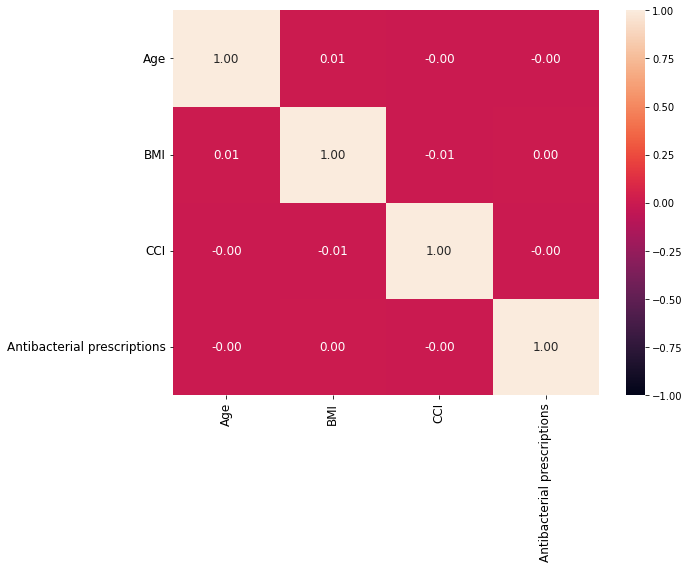

In [47]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(data_pneumonia[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=12)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=12)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_pneumonia/corr_pneumonia.jpg')
plt.show()

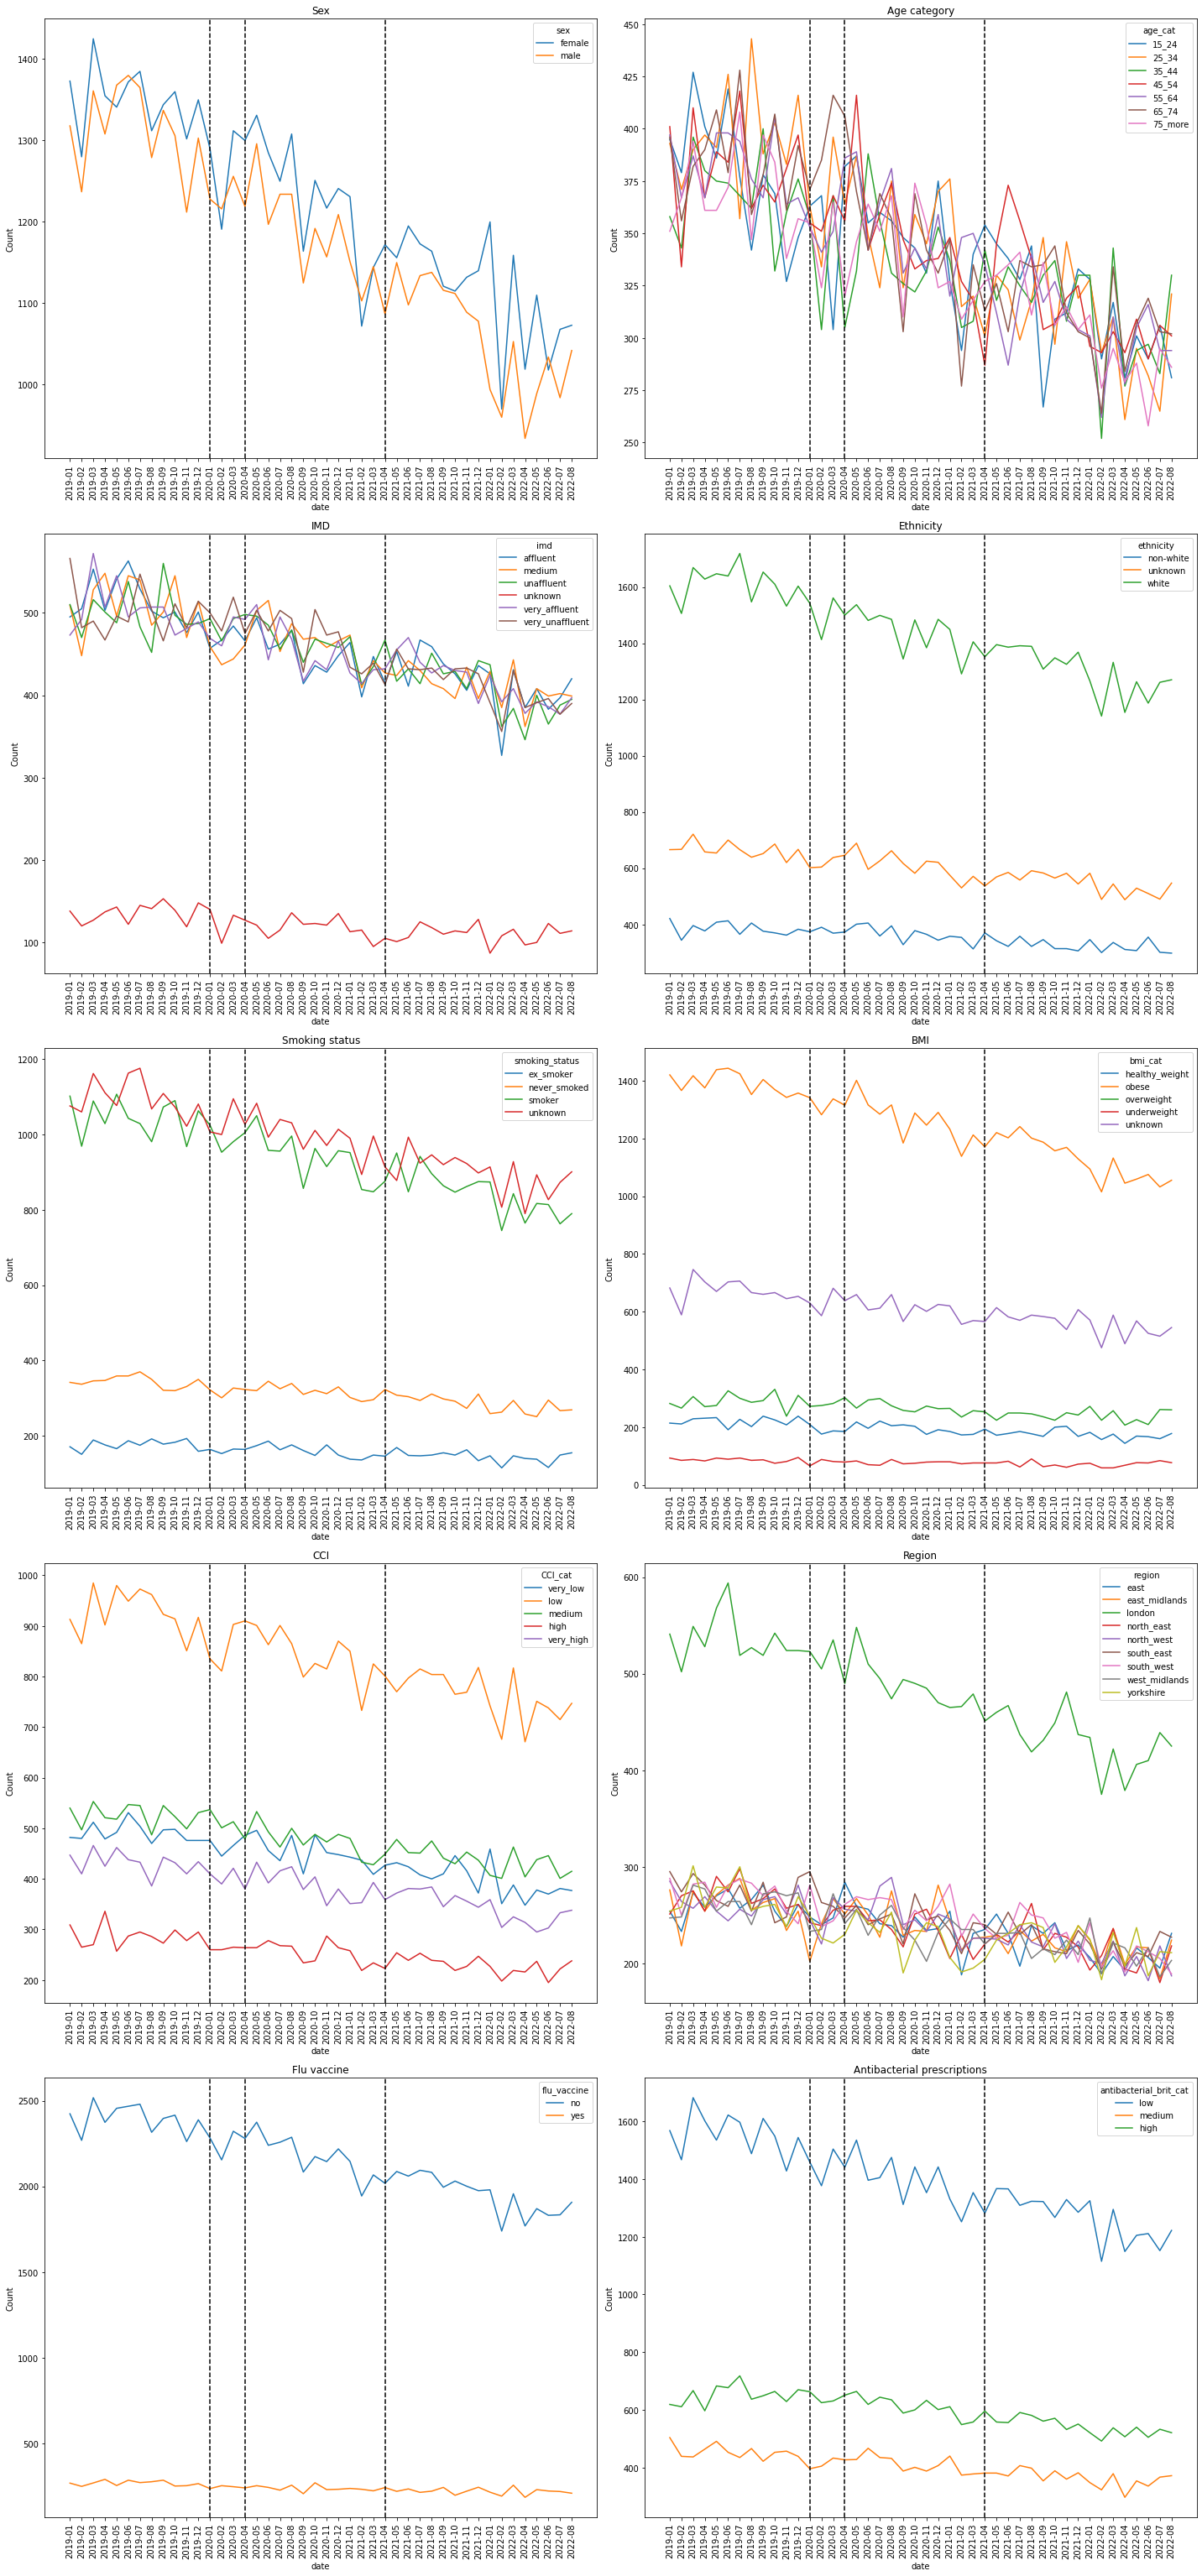

In [48]:
fig, axes = plt.subplots(5,2,
                        figsize=(20, 45)
                        )
create_lineplot(data_pneumonia, 'sex', 'Sex', axes[0,0])
create_lineplot(data_pneumonia, 'age_cat', 'Age category', axes[0,1])
create_lineplot(data_pneumonia, 'imd', 'IMD', axes[1,0])
create_lineplot(data_pneumonia, 'ethnicity', 'Ethnicity', axes[1,1])
create_lineplot(data_pneumonia, 'smoking_status', 'Smoking status', axes[2,0])
create_lineplot(data_pneumonia, 'bmi_cat', 'BMI', axes[2,1])
create_lineplot(data_pneumonia, 'CCI_cat', 'CCI', axes[3,0])
create_lineplot(data_pneumonia, 'region', 'Region', axes[3,1])
create_lineplot(data_pneumonia, 'flu_vaccine', 'Flu vaccine', axes[4,0])
create_lineplot(data_pneumonia, 'antibacterial_brit_cat', 'Antibacterial prescriptions', axes[4,1])
# fig.delaxes(ax=axes[5,1])

# fig.suptitle('Risk Factors of pneumonia patients', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_pneumonia/risk_factors_cat_pneumonia.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics
We separate data of pneumonia to form four sub-datasets for 1) no antibiotics and incident admission, 2) with antibiotics and incident admission, 3) no antibiotics and prevalent admission, and 4) with antiobiotics and prevalent admission.

In [49]:
data_pneumonia = data_pneumonia[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 
                       'antibacterial_brit', 'pneumonia_ab_date', 'ab_type_cat', 'incdt_pneumonia_date', 'date', 'period',
                       'event_pneumonia_admitted', 'duration_pneumonia_admitted'
                        ]]

data_pneumonia.shape

(105499, 17)

In [50]:
#incident and prevalent infection 
data_pneumonia_incdt = data_pneumonia[data_pneumonia['incdt_pneumonia_date'] == 0]
data_pneumonia_prevl = data_pneumonia[data_pneumonia['incdt_pneumonia_date'] == 1]
#switch variable pneumonia_ab_date into a binary variable
data_pneumonia_incdt[['pneumonia_ab_date']] = data_pneumonia_incdt[['pneumonia_ab_date']].where(data_pneumonia_incdt[['pneumonia_ab_date']].isnull(), 1).fillna(0).astype(int)
data_pneumonia_prevl[['pneumonia_ab_date']] = data_pneumonia_prevl[['pneumonia_ab_date']].where(data_pneumonia_prevl[['pneumonia_ab_date']].isnull(), 1).fillna(0).astype(int)

#incident and prevalent infection stratified by sex categories
data_pneumonia_incdt_males = data_pneumonia_incdt[data_pneumonia_incdt['sex'] == 'male']
data_pneumonia_incdt_females = data_pneumonia_incdt[data_pneumonia_incdt['sex'] == 'female']
data_pneumonia_prevl_males = data_pneumonia_prevl[data_pneumonia_prevl['sex'] == 'male']
data_pneumonia_prevl_females = data_pneumonia_prevl[data_pneumonia_prevl['sex'] == 'female']

#incident and prevalent infection stratified by age categories
data_pneumonia_incdt_15_24 = data_pneumonia_incdt[data_pneumonia_incdt['age_cat'] == '15_24']
data_pneumonia_incdt_25_34 = data_pneumonia_incdt[data_pneumonia_incdt['age_cat'] == '25_34']
data_pneumonia_incdt_35_44 = data_pneumonia_incdt[data_pneumonia_incdt['age_cat'] == '35_44']
data_pneumonia_incdt_45_54 = data_pneumonia_incdt[data_pneumonia_incdt['age_cat'] == '45_54']
data_pneumonia_incdt_55_64 = data_pneumonia_incdt[data_pneumonia_incdt['age_cat'] == '55_64']
data_pneumonia_incdt_65_74 = data_pneumonia_incdt[data_pneumonia_incdt['age_cat'] == '65_74']
data_pneumonia_incdt_75_more = data_pneumonia_incdt[data_pneumonia_incdt['age_cat'] == '75_more']
data_pneumonia_prevl_15_24 = data_pneumonia_prevl[data_pneumonia_prevl['age_cat'] == '15_24']
data_pneumonia_prevl_25_34 = data_pneumonia_prevl[data_pneumonia_prevl['age_cat'] == '25_34']
data_pneumonia_prevl_35_44 = data_pneumonia_prevl[data_pneumonia_prevl['age_cat'] == '35_44']
data_pneumonia_prevl_45_54 = data_pneumonia_prevl[data_pneumonia_prevl['age_cat'] == '45_54']
data_pneumonia_prevl_55_64 = data_pneumonia_prevl[data_pneumonia_prevl['age_cat'] == '55_64']
data_pneumonia_prevl_65_74 = data_pneumonia_prevl[data_pneumonia_prevl['age_cat'] == '65_74']
data_pneumonia_prevl_75_more = data_pneumonia_prevl[data_pneumonia_prevl['age_cat'] == '75_more']

data_pneumonia_incdt_prepandemic = data_pneumonia_incdt[data_pneumonia_incdt['date'] <= '2019-12']
data_pneumonia_incdt_during_pandemic = data_pneumonia_incdt[(data_pneumonia_incdt['date'] >= '2020-03') & (data_pneumonia_incdt['date']<= '2021-03')]
data_pneumonia_incdt_post_2nd_lockdown = data_pneumonia_incdt[data_pneumonia_incdt['date'] <= '2021-04']
data_pneumonia_prevl_prepandemic = data_pneumonia_prevl[data_pneumonia_prevl['date'] <= '2019-12']
data_pneumonia_prevl_during_pandemic = data_pneumonia_prevl[(data_pneumonia_prevl['date'] >= '2020-03') & (data_pneumonia_prevl['date']<= '2021-03')]
data_pneumonia_prevl_post_2nd_lockdown = data_pneumonia_prevl[data_pneumonia_prevl['date'] <= '2021-04']

# #incident and prevalent infection stratified by ab categories
# data_pneumonia_incdt_abtype_0 = data_pneumonia_incdt[data_pneumonia_incdt['ab_type_cat'] == data_pneumonia['ab_type_cat'].unique()[0]]
# data_pneumonia_incdt_abtype_1 = data_pneumonia_incdt[data_pneumonia_incdt['ab_type_cat'] == data_pneumonia['ab_type_cat'].unique()[1]]
# data_pneumonia_incdt_abtype_2 = data_pneumonia_incdt[data_pneumonia_incdt['ab_type_cat'] == data_pneumonia['ab_type_cat'].unique()[2]]
# data_pneumonia_incdt_abtype_3 = data_pneumonia_incdt[data_pneumonia_incdt['ab_type_cat'] == data_pneumonia['ab_type_cat'].unique()[3]]
# data_pneumonia_prevl_abtype_0 = data_pneumonia_prevl[data_pneumonia_prevl['ab_type_cat'] == data_pneumonia['ab_type_cat'].unique()[0]]
# data_pneumonia_prevl_abtype_1 = data_pneumonia_prevl[data_pneumonia_prevl['ab_type_cat'] == data_pneumonia['ab_type_cat'].unique()[1]]
# data_pneumonia_prevl_abtype_2 = data_pneumonia_prevl[data_pneumonia_prevl['ab_type_cat'] == data_pneumonia['ab_type_cat'].unique()[2]]
# data_pneumonia_prevl_abtype_3 = data_pneumonia_prevl[data_pneumonia_prevl['ab_type_cat'] == data_pneumonia['ab_type_cat'].unique()[3]]

# #incident and prevalent infection with antibiotics type
# data_pneumonia_incdt_abs = data_pneumonia_incdt[data_pneumonia_incdt['pneumonia_ab_date'] == 1]
# data_pneumonia_prevl_abs = data_pneumonia_prevl[data_pneumonia_prevl['pneumonia_ab_date'] == 1]

# no antibiotics and incident hospital admission
data_pneumonia_no_abs_incdt = data_pneumonia[data_pneumonia['pneumonia_ab_date'].isnull()] #gp_cons_pneumonia_ab
data_pneumonia_no_abs_incdt = data_pneumonia_no_abs_incdt[data_pneumonia_no_abs_incdt['incdt_pneumonia_date'] == 0]

# with antibiotics and incident hospital admission
data_pneumonia_abs_incdt = data_pneumonia[data_pneumonia['pneumonia_ab_date'].notnull()]
data_pneumonia_abs_incdt = data_pneumonia_abs_incdt[data_pneumonia_abs_incdt['incdt_pneumonia_date'] == 0]

# no antibiotics and prevalent hospital admission
data_pneumonia_no_abs_prevl = data_pneumonia[data_pneumonia['pneumonia_ab_date'].isnull()]
data_pneumonia_no_abs_prevl = data_pneumonia_no_abs_prevl[data_pneumonia_no_abs_prevl['incdt_pneumonia_date'] == 1]

# with antibiotics and prevalent hospital admission
data_pneumonia_abs_prevl = data_pneumonia[data_pneumonia['pneumonia_ab_date'].notnull()]
data_pneumonia_abs_prevl = data_pneumonia_abs_prevl[data_pneumonia_abs_prevl['incdt_pneumonia_date'] == 1]

print(f'shape of data_pneumonia_incdt: {data_pneumonia_incdt.shape}')
print(f'shape of data_pneumonia_prevl: {data_pneumonia_prevl.shape}')
print(f'shape of data_pneumonia_no_abs_incdt: {data_pneumonia_no_abs_incdt.shape}')
print(f'shape of data_pneumonia_abs_incdt: {data_pneumonia_abs_incdt.shape}')
print(f'shape of data_pneumonia_no_abs_prevl: {data_pneumonia_no_abs_prevl.shape}')
print(f'shape of data_pneumonia_abs_prevl: {data_pneumonia_abs_prevl.shape}')
print(f'\nvalue counts of data_pneumonia_no_abs_incdt: \n{data_pneumonia_no_abs_incdt.event_pneumonia_admitted.value_counts()}')
print(f'value counts of data_pneumonia_abs_incdt: \n{data_pneumonia_abs_incdt.event_pneumonia_admitted.value_counts()}')
print(f'value counts of data_pneumonia_no_abs_prevl: \n{data_pneumonia_no_abs_prevl.event_pneumonia_admitted.value_counts()}')
print(f'value counts of data_pneumonia_abs_prevl: \n{data_pneumonia_abs_prevl.event_pneumonia_admitted.value_counts()}')

shape of data_pneumonia_incdt: (94773, 17)
shape of data_pneumonia_prevl: (10726, 17)
shape of data_pneumonia_no_abs_incdt: (85363, 17)
shape of data_pneumonia_abs_incdt: (9410, 17)
shape of data_pneumonia_no_abs_prevl: (9692, 17)
shape of data_pneumonia_abs_prevl: (1034, 17)

value counts of data_pneumonia_no_abs_incdt: 
0.0    84764
1.0      599
Name: event_pneumonia_admitted, dtype: int64
value counts of data_pneumonia_abs_incdt: 
0.0    9342
1.0      68
Name: event_pneumonia_admitted, dtype: int64
value counts of data_pneumonia_no_abs_prevl: 
0.0    9626
1.0      66
Name: event_pneumonia_admitted, dtype: int64
value counts of data_pneumonia_abs_prevl: 
0.0    1031
1.0       3
Name: event_pneumonia_admitted, dtype: int64


In [51]:
#store data for plotting hosp admission counts and percentages
%store data_pneumonia
# save data
data_pneumonia.to_csv('../output/hospitalisation_prediction_pneumonia/data_pneumonia.csv')

Stored 'data_pneumonia' (DataFrame)


## 5- cox modelling for hospital admissions
### 5-1- incident pneumonia with no antibiotics

<lifelines.CoxPHFitter: fitted with 64022 total observations, 63565 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 64022
number of events observed = 457
   partial log-likelihood = -5038.06
         time fit was run = 2022-11-17 10:39:05 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.06       0.94       0.13            -0.32             0.19                 0.73                 1.21
CCI_cat[T.medium]               -0.16       0.85       0.15            -0.45             0.14                 0.64                 1.15
CCI_cat[T.high]                 -0.24       0.79       0.19            -0.60             0.13                 0.55                 1.13
CCI_cat[T.very_high]            -0.10       0.91       0.16            -0.40             0.21                 0.67                 1.24
age_cat[T.25_34]                 0.03       1.03       0.17            -0.30             0.36                 0.74                 1.43
age_cat[T.35_44]                -0.19       0.83       0.18            -0.54             0.16                 0.58                 1.17
age_cat[T.45_54]                 0.12       1.13       0.16            -0.20             0.45                 0.82                 1.56
age_cat[T.55_64]                -0.13       0.87       0.18            -0.48             0.21                 0.62                 1.23
age_cat[T.65_74]                -0.07       0.93       0.17            -0.41             0.27                 0.66                 1.31
age_cat[T.75_more]              -0.27       0.76       0.18            -0.63             0.08                 0.53                 1.09
antibacterial_brit               0.01       1.01       0.03            -0.05             0.08                 0.95                 1.08
bmi_cat[T.obese]                -0.20       0.82       0.17            -0.53             0.13                 0.59                 1.14
bmi_cat[T.overweight]           -0.37       0.69       0.22            -0.81             0.06                 0.44                 1.06
bmi_cat[T.underweight]           0.27       1.31       0.26            -0.25             0.78                 0.78                 2.19
bmi_cat[T.unknown]              -0.01       0.99       0.18            -0.36             0.34                 0.70                 1.40
ethnicity[T.unknown]            -0.09       0.91       0.15            -0.40             0.21                 0.67                 1.23
ethnicity[T.white]               0.01       1.01       0.13            -0.25             0.27                 0.78                 1.31
flu_vaccine[T.yes]              -0.01       0.99       0.16            -0.32             0.30                 0.73                 1.34
imd[T.medium]                   -0.01       0.99       0.14            -0.30             0.27                 0.74                 1.31
imd[T.unaffluent]               -0.09       0.92       0.15            -0.38             0.20                 0.69                 1.23
imd[T.unknown]                  -0.03       0.97       0.22            -0.47             0.41                 0.63                 1.51
imd[T.very_affluent]            -0.24       0.79       0.15            -0.54             0.06                 0.58                 1.06
imd[T.very_unaffluent]          -0.22       0.80       0.15            -0.52             0.08                 0.59                 1.08
region[T.east_midlands]         -0.16       0.85       0.20            -0.56             0.24                 0.57                 1.27
region[T.london]                -0.21       0.81       0.1

12804


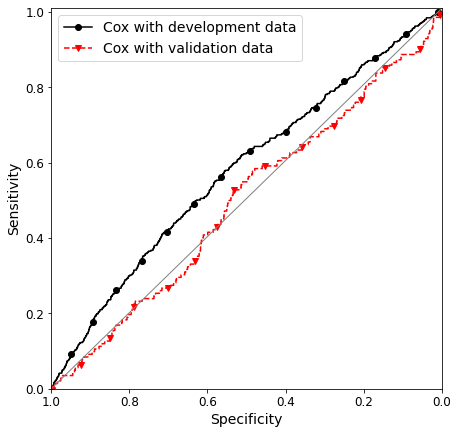

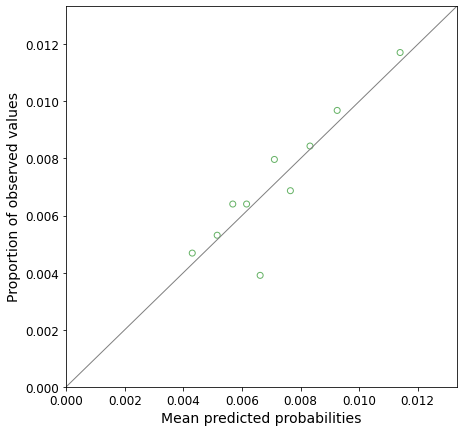

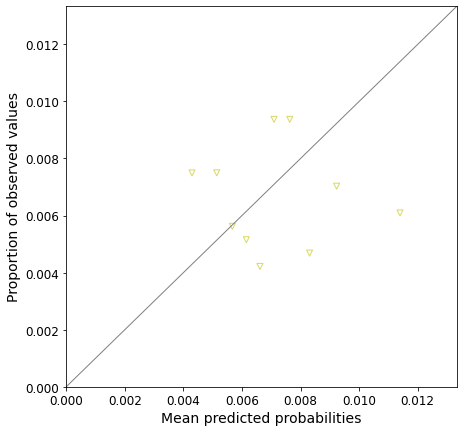

In [52]:
#data prep
data, data_pneumonia_no_abs_incdt_enc = cox_data_prep(data_pneumonia_no_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

#make summary table
make_summary_table('pneumonia', 'no_abs_incdt', data_pneumonia_no_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('pneumonia', 'no_abs_incdt', data_pneumonia_no_abs_incdt)

try:
    #build cox model 
    cph_pneumonia_no_abs_incdt, data_pneumonia_no_abs_incdt_train, data_pneumonia_no_abs_incdt_test = cox_model_build('pneumonia', 'no_abs_incdt', data_pneumonia_no_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_pneumonia_no_abs_incdt, '../output/hospitalisation_prediction_pneumonia/', 'betas_cph_pneumonia_no_abs_incdt.csv', data_pneumonia_no_abs_incdt_enc, data_pneumonia_no_abs_incdt, 'sum_betas_cph_pneumonia_no_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_pneumonia_no_abs_incdt, 'event_pneumonia_admitted', data_pneumonia_no_abs_incdt_train, data_pneumonia_no_abs_incdt_test, '../output/hospitalisation_prediction_pneumonia', 'roc_cph_pneumonia_no_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_pneumonia_no_abs_incdt, data_pneumonia_no_abs_incdt_train, 'event_pneumonia_admitted', data_pneumonia_no_abs_incdt_test, '../output/hospitalisation_prediction_pneumonia/', 'calibration_cph_pneumonia_no_abs_incdt_train.jpg', 'calibration_cph_pneumonia_no_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_pneumonia_no_abs_incdt, 'pneumonia', 'no_abs_incdt', data_pneumonia_no_abs_incdt_train, data_pneumonia_no_abs_incdt_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-2- incident pneumonia with antibiotics

<lifelines.CoxPHFitter: fitted with 7057 total observations, 7002 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 7057
number of events observed = 55
   partial log-likelihood = -470.56
         time fit was run = 2022-11-17 10:39:18 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.22       0.80       0.39            -0.99             0.55                 0.37                 1.74
CCI_cat[T.medium]                0.05       1.05       0.42            -0.77             0.88                 0.46                 2.40
CCI_cat[T.high]                 -0.78       0.46       0.65            -2.06             0.50                 0.13                 1.65
CCI_cat[T.very_high]             0.31       1.36       0.41            -0.50             1.12                 0.61                 3.05
age_cat[T.25_34]                -0.96       0.38       0.69            -2.32             0.39                 0.10                 1.48
age_cat[T.35_44]                 0.37       1.45       0.50            -0.60             1.34                 0.55                 3.83
age_cat[T.45_54]                 0.30       1.35       0.51            -0.69             1.29                 0.50                 3.63
age_cat[T.55_64]                -0.18       0.84       0.56            -1.27             0.92                 0.28                 2.50
age_cat[T.65_74]                 0.52       1.68       0.47            -0.40             1.44                 0.67                 4.24
age_cat[T.75_more]               0.02       1.02       0.54            -1.03             1.07                 0.36                 2.91
antibacterial_brit               0.01       1.01       0.09            -0.18             0.19                 0.84                 1.21
bmi_cat[T.obese]                 0.33       1.39       0.61            -0.86             1.53                 0.42                 4.61
bmi_cat[T.overweight]            0.22       1.25       0.73            -1.21             1.66                 0.30                 5.26
bmi_cat[T.underweight]           0.85       2.33       0.82            -0.76             2.45                 0.47                11.59
bmi_cat[T.unknown]               0.62       1.86       0.63            -0.61             1.85                 0.54                 6.38
ethnicity[T.unknown]             0.04       1.04       0.51            -0.96             1.04                 0.38                 2.82
ethnicity[T.white]               0.45       1.57       0.44            -0.41             1.32                 0.66                 3.73
flu_vaccine[T.yes]               0.31       1.36       0.41            -0.49             1.11                 0.61                 3.02
imd[T.medium]                   -0.08       0.92       0.46            -0.99             0.82                 0.37                 2.27
imd[T.unaffluent]               -0.30       0.74       0.49            -1.27             0.67                 0.28                 1.95
imd[T.unknown]                   0.50       1.64       0.60            -0.67             1.66                 0.51                 5.28
imd[T.very_affluent]             0.42       1.53       0.41            -0.38             1.23                 0.68                 3.42
imd[T.very_unaffluent]           0.02       1.02       0.45            -0.86             0.90                 0.42                 2.47
region[T.east_midlands]         -0.51       0.60       0.57            -1.64             0.61                 0.19                 1.84
region[T.london]                -0.51       0.60       0.48    

12778


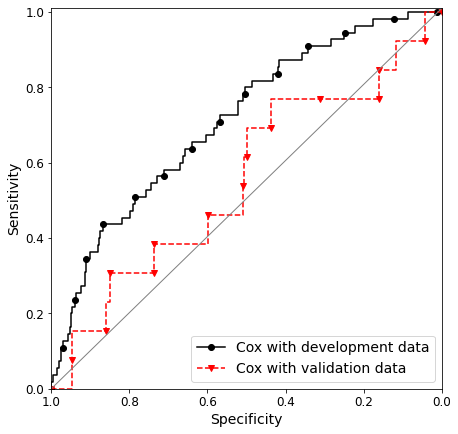

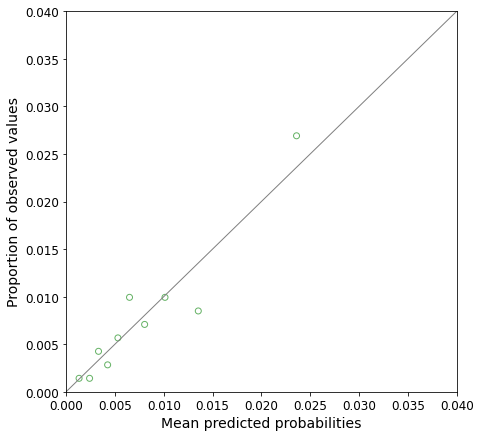

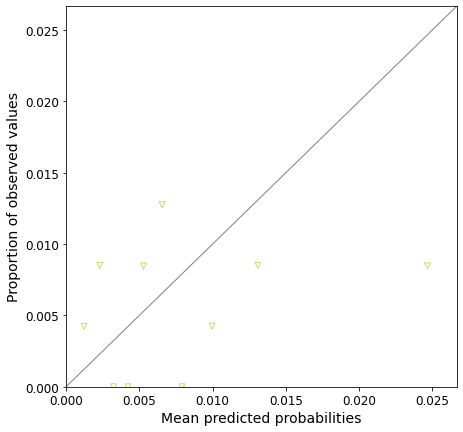

In [53]:
#data prep
data, data_pneumonia_abs_incdt_enc = cox_data_prep(data_pneumonia_abs_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

#make summary table
make_summary_table('pneumonia', 'abs_incdt', data_pneumonia_abs_incdt_enc)

#make summary table of hosped
make_summary_table_hosped('pneumonia', 'abs_incdt', data_pneumonia_abs_incdt)

try:
    #build cox model 
    cph_pneumonia_abs_incdt, data_pneumonia_abs_incdt_train, data_pneumonia_abs_incdt_test = cox_model_build('pneumonia', 'abs_incdt', data_pneumonia_abs_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_pneumonia_abs_incdt, '../output/hospitalisation_prediction_pneumonia/', 'betas_cph_pneumonia_abs_incdt.csv', data_pneumonia_abs_incdt_enc, data_pneumonia_abs_incdt, 'sum_betas_cph_pneumonia_abs_incdt.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_pneumonia_abs_incdt, 'event_pneumonia_admitted', data_pneumonia_abs_incdt_train, data_pneumonia_abs_incdt_test, '../output/hospitalisation_prediction_pneumonia', 'roc_cph_pneumonia_abs_incdt.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_pneumonia_abs_incdt, data_pneumonia_abs_incdt_train, 'event_pneumonia_admitted', data_pneumonia_abs_incdt_test, '../output/hospitalisation_prediction_pneumonia/', 'calibration_cph_pneumonia_abs_incdt_train.jpg', 'calibration_cph_pneumonia_abs_incdt_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_pneumonia_abs_incdt, 'pneumonia', 'abs_incdt', data_pneumonia_abs_incdt_train, data_pneumonia_abs_incdt_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-3- prevalent pneumonia with no antibiotics

<lifelines.CoxPHFitter: fitted with 7269 total observations, 7217 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 7269
number of events observed = 52
   partial log-likelihood = -444.12
         time fit was run = 2022-11-17 10:39:23 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.74       0.48       0.40            -1.53             0.05                 0.22                 1.05
CCI_cat[T.medium]               -0.36       0.70       0.42            -1.19             0.46                 0.30                 1.59
CCI_cat[T.high]                 -0.10       0.90       0.47            -1.02             0.82                 0.36                 2.28
CCI_cat[T.very_high]            -0.11       0.89       0.42            -0.94             0.72                 0.39                 2.05
age_cat[T.25_34]                 0.59       1.81       0.51            -0.41             1.59                 0.67                 4.91
age_cat[T.35_44]                 0.41       1.51       0.53            -0.62             1.45                 0.54                 4.26
age_cat[T.45_54]                 0.60       1.83       0.51            -0.39             1.60                 0.67                 4.96
age_cat[T.55_64]                -0.29       0.75       0.61            -1.48             0.90                 0.23                 2.45
age_cat[T.65_74]                -0.10       0.91       0.58            -1.23             1.04                 0.29                 2.82
age_cat[T.75_more]              -0.43       0.65       0.65            -1.70             0.83                 0.18                 2.30
antibacterial_brit              -0.01       0.99       0.10            -0.21             0.18                 0.81                 1.20
bmi_cat[T.obese]                 1.02       2.76       0.73            -0.42             2.45                 0.66                11.56
bmi_cat[T.overweight]            1.03       2.80       0.80            -0.54             2.61                 0.58                13.55
bmi_cat[T.underweight]           0.27       1.31       1.23            -2.13             2.68                 0.12                14.56
bmi_cat[T.unknown]               0.53       1.70       0.78            -0.99             2.05                 0.37                 7.79
ethnicity[T.unknown]            -0.18       0.84       0.54            -1.24             0.89                 0.29                 2.43
ethnicity[T.white]               0.50       1.66       0.44            -0.36             1.37                 0.70                 3.93
flu_vaccine[T.yes]              -0.55       0.57       0.60            -1.72             0.61                 0.18                 1.85
imd[T.medium]                    0.27       1.31       0.51            -0.72             1.26                 0.49                 3.52
imd[T.unaffluent]                0.55       1.73       0.48            -0.38             1.48                 0.68                 4.41
imd[T.unknown]                   1.09       2.97       0.59            -0.06             2.24                 0.94                 9.41
imd[T.very_affluent]             0.56       1.75       0.48            -0.38             1.49                 0.69                 4.45
imd[T.very_unaffluent]           0.06       1.06       0.54            -0.99             1.11                 0.37                 3.04
region[T.east_midlands]          0.41       1.50       0.65            -0.86             1.68                 0.42                 5.34
region[T.london]                 0.48       1.62       0.58    

12771


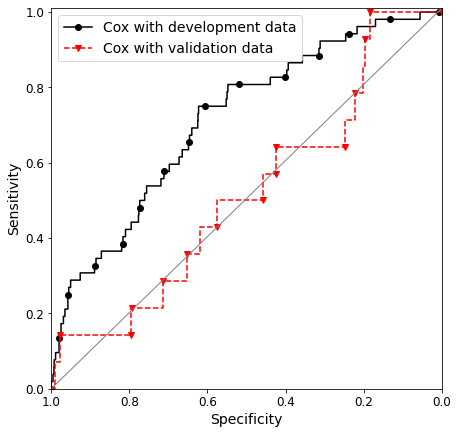

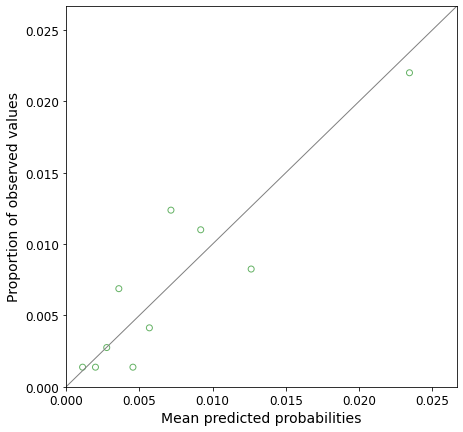

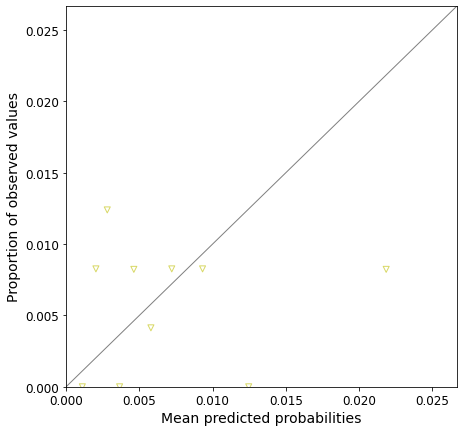

In [54]:
#data prep
data, data_pneumonia_no_abs_prevl_enc = cox_data_prep(data_pneumonia_no_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

#make summary table
make_summary_table('pneumonia', 'no_abs_prevl', data_pneumonia_no_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('pneumonia', 'no_abs_prevl', data_pneumonia_no_abs_prevl)

try:
    #build cox model 
    cph_pneumonia_no_abs_prevl, data_pneumonia_no_abs_prevl_train, data_pneumonia_no_abs_prevl_test = cox_model_build('pneumonia', 'no_abs_prevl', data_pneumonia_no_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:    
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_pneumonia_no_abs_prevl, '../output/hospitalisation_prediction_pneumonia/', 'betas_cph_pneumonia_no_abs_prevl.csv', data_pneumonia_no_abs_prevl_enc, data_pneumonia_no_abs_prevl, 'sum_betas_cph_pneumonia_no_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_pneumonia_no_abs_prevl, 'event_pneumonia_admitted', data_pneumonia_no_abs_prevl_train, data_pneumonia_no_abs_prevl_test, '../output/hospitalisation_prediction_pneumonia', 'roc_cph_pneumonia_no_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_pneumonia_no_abs_prevl, data_pneumonia_no_abs_prevl_train, 'event_pneumonia_admitted', data_pneumonia_no_abs_prevl_test, '../output/hospitalisation_prediction_pneumonia/', 'calibration_cph_pneumonia_no_abs_prevl_train.jpg', 'calibration_cph_pneumonia_no_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_pneumonia_no_abs_prevl, 'pneumonia', 'no_abs_prevl', data_pneumonia_no_abs_prevl_train, data_pneumonia_no_abs_prevl_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

### 5-4- prevalent pneumonia with antibiotics

In [55]:
#data prep
data, data_pneumonia_abs_prevl_enc = cox_data_prep(data_pneumonia_abs_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'period'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

#make summary table
make_summary_table('pneumonia', 'abs_prevl', data_pneumonia_abs_prevl_enc)

#make summary table of hosped
make_summary_table_hosped('pneumonia', 'abs_prevl', data_pneumonia_abs_prevl)

try:
    #build cox model 
    cph_pneumonia_abs_prevl, data_pneumonia_abs_prevl_train, data_pneumonia_abs_prevl_test = cox_model_build('pneumonia', 'abs_prevl', data_pneumonia_abs_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    #calculate and save betas and sum of betas 
    betas_sumbetas_calculate(cph_pneumonia_abs_prevl, '../output/hospitalisation_prediction_pneumonia/', 'betas_cph_pneumonia_abs_prevl.csv', data_pneumonia_abs_prevl_enc, data_pneumonia_abs_prevl, 'sum_betas_cph_pneumonia_abs_prevl.csv')
except:
    print("\nerror_2: betas or sum of betas failed.")

try:
    #plot roc curve
    cph_roc_curve(cph_pneumonia_abs_prevl, 'event_pneumonia_admitted', data_pneumonia_abs_prevl_train, data_pneumonia_abs_prevl_test, '../output/hospitalisation_prediction_pneumonia', 'roc_cph_pneumonia_abs_prevl.jpg')

    #plot calibration plots with development and validation data
    cph_calibration(cph_pneumonia_abs_prevl, data_pneumonia_abs_prevl_train, 'event_pneumonia_admitted', data_pneumonia_abs_prevl_test, '../output/hospitalisation_prediction_pneumonia/', 'calibration_cph_pneumonia_abs_prevl_train.jpg', 'calibration_cph_pneumonia_abs_prevl_test.jpg')
except:
    print("\nerror_3: roc curves or calibration curves failed.")

try:
    # calculate c-statistics
    cph_output(cph_pneumonia_abs_prevl, 'pneumonia', 'abs_prevl', data_pneumonia_abs_prevl_train, data_pneumonia_abs_prevl_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 775 total observations, 772 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 775
number of events observed = 3
   partial log-likelihood = -0.00
         time fit was run = 2022-11-17 10:39:27 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -2.69       0.07    1311.11         -2572.43          2567.05                 0.00                  inf
CCI_cat[T.medium]               -2.74       0.06    2673.74         -5243.17          5237.68                 0.00                  inf
CCI_cat[T.high]                -21.89       0.00    2133.43         -4203.35          4159.56                 0.00                  inf
CCI_cat[T.very_high]            -7.44       0.00    2862.80         -5618.42          5603.53                 0.00                  inf
age_cat[T.25_34]               -10.11       0.00    2119.10         -4163.46          4143.24                 0.00                  inf
age_cat[T.35_44]               -24.58       0.00    3451.87         -6790.13          6740.97                 0.00                  inf
age_cat[T.45_54]                 1.66       5.24    2059.49         -4034.88          4038.19                 0.00                  inf
age_cat[T.55_64]               -14.28       0.00    2841.82         -5584.14          5555.59                 0.00                  inf
age_cat[T.65_74]               -19.42       0.00    4006.12         -7871.26          7832.42                 0.00                  inf
age_cat[T.75_more]             -17.17       0.00    2726.18         -5360.38          5326.05                 0.00                  inf
antibacterial_brit              -0.29       0.75     477.27          -935.73           935.15                 0.00                  inf
bmi_cat[T.obese]                 7.06    1159.52    4145.74         -8118.45          8132.57                 0.00                  inf
bmi_cat[T.overweight]           24.40   3.96e+10    3783.24         -7390.62          7439.42                 0.00                  inf
bmi_cat[T.underweight]          -3.10       0.05    4220.74         -8275.60          8269.41                 0.00                  inf
bmi_cat[T.unknown]              28.43   2.23e+12    2492.72         -4857.21          4914.08                 0.00                  inf
ethnicity[T.unknown]             9.79   17877.98    3155.39         -6174.65          6194.24                 0.00                  inf
ethnicity[T.white]               5.66     286.70    2723.63         -5332.56          5343.87                 0.00                  inf
flu_vaccine[T.yes]             -10.79       0.00    4407.54         -8649.41          8627.83                 0.00                  inf
imd[T.medium]                  -13.42       0.00    3859.18         -7577.28          7550.44                 0.00                  inf
imd[T.unaffluent]               -3.23       0.04    3386.24         -6640.13          6633.67                 0.00                  inf
imd[T.unknown]                   5.83     341.55    5483.03        -10740.71         10752.37                 0.00                  inf
imd[T.very_affluent]             5.34     207.90    3190.77         -6248.46          6259.14                 0.00                  inf
imd[T.very_unaffluent]          13.51   7.38e+05    2431.40         -4751.94          4778.97                 0.00                  inf
region[T.east_midlands]         -3.21       0.04    8723.73        -17101.42         17094.99                 0.00                  inf
region[T.london]                13.81   9.92e+05    5788.03        -1

13157

error_3: roc curves or calibration curves failed.

error_4: an error occurred in calculating c-stats of validation dataset and/or printing outputs.


ValueError: arange: cannot compute length

<Figure size 504x504 with 1 Axes>

### 5-5- incident pneumonia

In [56]:
#data prep
data, data_pneumonia_incdt_enc = cox_data_prep(data_pneumonia_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

#make summary tables from preped data
make_summary_table('pneumonia', 'incdt', data_pneumonia_incdt_enc)
make_summary_table_hosped('pneumonia', 'incdt', data_pneumonia_incdt)

try:
    cph_pneumonia_incdt, data_pneumonia_incdt_train, data_pneumonia_incdt_test = cox_model_abs_build('pneumonia', 'incdt', data_pneumonia_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_pneumonia_incdt, 'pneumonia', 'incdt', data_pneumonia_incdt_train, data_pneumonia_incdt_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 71079 total observations, 70570 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 71079
number of events observed = 509
   partial log-likelihood = -5666.44
         time fit was run = 2022-11-17 10:42:03 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.06       0.94       0.13            -0.31             0.18                 0.73                 1.20
CCI_cat[T.medium]               -0.01       0.99       0.14            -0.29             0.27                 0.75                 1.31
CCI_cat[T.high]                 -0.14       0.87       0.18            -0.49             0.20                 0.61                 1.23
CCI_cat[T.very_high]             0.06       1.06       0.15            -0.23             0.35                 0.79                 1.41
age_cat[T.25_34]                 0.10       1.11       0.17            -0.23             0.43                 0.80                 1.54
age_cat[T.35_44]                -0.01       0.99       0.17            -0.35             0.33                 0.70                 1.38
age_cat[T.45_54]                 0.23       1.26       0.16            -0.09             0.55                 0.92                 1.74
age_cat[T.55_64]                 0.10       1.11       0.17            -0.23             0.44                 0.80                 1.55
age_cat[T.65_74]                 0.09       1.09       0.17            -0.24             0.42                 0.78                 1.52
age_cat[T.75_more]               0.01       1.01       0.17            -0.33             0.35                 0.72                 1.42
antibacterial_brit               0.03       1.03       0.03            -0.03             0.09                 0.97                 1.09
bmi_cat[T.obese]                -0.21       0.81       0.16            -0.52             0.10                 0.60                 1.11
bmi_cat[T.overweight]           -0.32       0.73       0.20            -0.72             0.09                 0.49                 1.09
bmi_cat[T.underweight]           0.13       1.13       0.26            -0.38             0.63                 0.68                 1.88
bmi_cat[T.unknown]              -0.07       0.93       0.17            -0.40             0.26                 0.67                 1.29
ethnicity[T.unknown]            -0.12       0.88       0.15            -0.41             0.16                 0.66                 1.18
ethnicity[T.white]              -0.01       0.99       0.13            -0.26             0.24                 0.77                 1.27
flu_vaccine[T.yes]              -0.06       0.94       0.15            -0.36             0.23                 0.70                 1.26
imd[T.medium]                    0.03       1.03       0.14            -0.24             0.31                 0.79                 1.36
imd[T.unaffluent]                0.00       1.00       0.14            -0.28             0.28                 0.76                 1.33
imd[T.unknown]                  -0.02       0.98       0.22            -0.46             0.41                 0.63                 1.50
imd[T.very_affluent]             0.01       1.02       0.14            -0.26             0.29                 0.77                 1.34
imd[T.very_unaffluent]          -0.23       0.80       0.15            -0.52             0.07                 0.59                 1.07
pneumonia_ab_date                0.03       1.03       0.15            -0.26             0.31                 0.77                 1.37
region[T.east_midlands]         -0.13       0.88       0.1

13072


### 5-6- hospital admission related to prevalent pneumonia

In [57]:
#data prep
data, data_pneumonia_prevl_enc = cox_data_prep(data_pneumonia_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

#make summary tables from preped data
make_summary_table('pneumonia', 'prevl', data_pneumonia_prevl_enc)
make_summary_table_hosped('pneumonia', 'prevl', data_pneumonia_prevl)

try:
    cph_pneumonia_prevl, data_pneumonia_prevl_train, data_pneumonia_prevl_test = cox_model_abs_build('pneumonia', 'prevl', data_pneumonia_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_pneumonia_prevl, 'pneumonia', 'prevl', data_pneumonia_prevl_train, data_pneumonia_prevl_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 8044 total observations, 7990 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 8044
number of events observed = 54
   partial log-likelihood = -463.62
         time fit was run = 2022-11-17 10:42:13 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.55       0.58       0.40            -1.34             0.24                 0.26                 1.27
CCI_cat[T.medium]                0.02       1.03       0.40            -0.76             0.81                 0.47                 2.25
CCI_cat[T.high]                  0.20       1.22       0.44            -0.67             1.07                 0.51                 2.92
CCI_cat[T.very_high]            -0.34       0.71       0.48            -1.28             0.60                 0.28                 1.81
age_cat[T.25_34]                 0.60       1.82       0.51            -0.40             1.60                 0.67                 4.95
age_cat[T.35_44]                 0.69       2.00       0.51            -0.31             1.69                 0.73                 5.42
age_cat[T.45_54]                 0.60       1.83       0.51            -0.39             1.60                 0.67                 4.95
age_cat[T.55_64]                -0.23       0.79       0.61            -1.42             0.96                 0.24                 2.61
age_cat[T.65_74]                -0.24       0.78       0.61            -1.43             0.95                 0.24                 2.58
age_cat[T.75_more]              -0.15       0.86       0.61            -1.34             1.04                 0.26                 2.83
antibacterial_brit               0.02       1.02       0.09            -0.16             0.21                 0.85                 1.23
bmi_cat[T.obese]                 1.55       4.70       1.02            -0.45             3.54                 0.64                34.53
bmi_cat[T.overweight]            1.75       5.78       1.06            -0.33             3.84                 0.72                46.40
bmi_cat[T.underweight]           0.94       2.56       1.42            -1.84             3.72                 0.16                41.13
bmi_cat[T.unknown]               1.49       4.44       1.04            -0.54             3.52                 0.58                33.82
ethnicity[T.unknown]            -0.51       0.60       0.50            -1.49             0.48                 0.23                 1.61
ethnicity[T.white]               0.19       1.21       0.39            -0.58             0.95                 0.56                 2.59
flu_vaccine[T.yes]              -0.60       0.55       0.60            -1.77             0.56                 0.17                 1.76
imd[T.medium]                    0.59       1.80       0.52            -0.43             1.60                 0.65                 4.95
imd[T.unaffluent]                0.69       2.00       0.51            -0.30             1.69                 0.74                 5.41
imd[T.unknown]                   0.31       1.36       0.82            -1.29             1.92                 0.27                 6.79
imd[T.very_affluent]             1.06       2.88       0.48             0.13             1.99                 1.13                 7.32
imd[T.very_unaffluent]           0.32       1.38       0.54            -0.74             1.38                 0.48                 3.98
pneumonia_ab_date               -1.04       0.35       0.72            -2.45             0.38                 0.09                 1.46
region[T.east_midlands]          0.84       2.31       0.84    

13046


### 5-7- hospital admission related to incident pneumonia with prescribed antibiotics categories

In [58]:
#data prep
data, data_pneumonia_incdt_abs_enc = cox_data_prep(data_pneumonia_incdt, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_incdt_abs, data_pneumonia_incdt_abs_train, data_pneumonia_incdt_abs_test = cox_model_ab_type_build('pneumonia', 'incdt_ab_type', data_pneumonia_incdt)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_pneumonia_incdt_abs, 'pneumonia', 'incdt_abs', data_pneumonia_incdt_abs_train, data_pneumonia_incdt_abs_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 71079 total observations, 70570 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 71079
number of events observed = 509
   partial log-likelihood = -5666.23
         time fit was run = 2022-11-17 10:42:15 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.06       0.94       0.13            -0.31             0.19                 0.73                 1.20
CCI_cat[T.medium]               -0.01       0.99       0.14            -0.29             0.27                 0.75                 1.31
CCI_cat[T.high]                 -0.14       0.87       0.18            -0.49             0.20                 0.61                 1.23
CCI_cat[T.very_high]             0.06       1.06       0.15            -0.23             0.35                 0.79                 1.41
ab_type_cat[T.Doxycycline]       0.43       1.53       1.23            -1.98             2.83                 0.14                16.89
ab_type_cat[T.no]                0.39       1.48       0.71            -1.00             1.78                 0.37                 5.95
ab_type_cat[T.other]             0.44       1.56       0.72            -0.97             1.86                 0.38                 6.40
age_cat[T.25_34]                 0.10       1.11       0.17            -0.23             0.43                 0.80                 1.54
age_cat[T.35_44]                -0.02       0.98       0.17            -0.36             0.32                 0.70                 1.38
age_cat[T.45_54]                 0.23       1.26       0.16            -0.09             0.55                 0.92                 1.74
age_cat[T.55_64]                 0.10       1.11       0.17            -0.23             0.44                 0.80                 1.55
age_cat[T.65_74]                 0.09       1.09       0.17            -0.24             0.42                 0.78                 1.52
age_cat[T.75_more]               0.01       1.01       0.17            -0.33             0.35                 0.72                 1.42
antibacterial_brit               0.03       1.03       0.03            -0.03             0.09                 0.97                 1.09
bmi_cat[T.obese]                -0.21       0.81       0.16            -0.52             0.10                 0.60                 1.11
bmi_cat[T.overweight]           -0.31       0.73       0.20            -0.72             0.09                 0.49                 1.09
bmi_cat[T.underweight]           0.13       1.13       0.26            -0.38             0.63                 0.68                 1.88
bmi_cat[T.unknown]              -0.07       0.93       0.17            -0.40             0.26                 0.67                 1.29
ethnicity[T.unknown]            -0.12       0.88       0.15            -0.41             0.16                 0.66                 1.17
ethnicity[T.white]              -0.01       0.99       0.13            -0.26             0.24                 0.77                 1.27
flu_vaccine[T.yes]              -0.06       0.94       0.15            -0.36             0.23                 0.70                 1.26
imd[T.medium]                    0.03       1.03       0.14            -0.24             0.31                 0.79                 1.36
imd[T.unaffluent]                0.00       1.00       0.14            -0.28             0.28                 0.76                 1.33
imd[T.unknown]                  -0.02       0.98       0.22            -0.46             0.41                 0.63                 1.51
imd[T.very_affluent]             0.02       1.02       0.1

13636


### 5-8- hospital admission related to prevalent pneumonia with prescribed antibiotics categories

In [59]:
#data prep
data, data_pneumonia_prevl_abs_enc = cox_data_prep(data_pneumonia_prevl, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'ab_type_cat'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_prevl_abs, data_pneumonia_prevl_abs_train, data_pneumonia_prevl_abs_test = cox_model_ab_type_build('pneumonia', 'prevl_ab_type', data_pneumonia_prevl)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_pneumonia_prevl_abs, 'pneumonia', 'prevl_abs', data_pneumonia_prevl_abs_train, data_pneumonia_prevl_abs_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 8044 total observations, 7990 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 8044
number of events observed = 54
   partial log-likelihood = -463.48
         time fit was run = 2022-11-17 10:42:21 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.55       0.58       0.40            -1.34             0.24                 0.26                 1.27
CCI_cat[T.medium]                0.03       1.03       0.40            -0.76             0.81                 0.47                 2.26
CCI_cat[T.high]                  0.20       1.22       0.44            -0.67             1.07                 0.51                 2.91
CCI_cat[T.very_high]            -0.34       0.71       0.48            -1.27             0.60                 0.28                 1.82
ab_type_cat[T.Doxycycline]      -0.21       0.81    5986.56        -11733.65         11733.24                 0.00                  inf
ab_type_cat[T.no]               14.81   2.70e+06    3223.35         -6302.84          6332.46                 0.00                  inf
ab_type_cat[T.other]            13.85   1.03e+06    3223.35         -6303.80          6331.49                 0.00                  inf
age_cat[T.25_34]                 0.60       1.83       0.51            -0.40             1.60                 0.67                 4.96
age_cat[T.35_44]                 0.69       2.00       0.51            -0.31             1.69                 0.74                 5.44
age_cat[T.45_54]                 0.60       1.83       0.51            -0.39             1.60                 0.67                 4.95
age_cat[T.55_64]                -0.23       0.80       0.61            -1.42             0.96                 0.24                 2.62
age_cat[T.65_74]                -0.24       0.79       0.61            -1.43             0.95                 0.24                 2.58
age_cat[T.75_more]              -0.15       0.86       0.61            -1.34             1.04                 0.26                 2.84
antibacterial_brit               0.02       1.02       0.09            -0.16             0.21                 0.85                 1.23
bmi_cat[T.obese]                 1.55       4.70       1.02            -0.45             3.54                 0.64                34.54
bmi_cat[T.overweight]            1.75       5.78       1.06            -0.33             3.84                 0.72                46.40
bmi_cat[T.underweight]           0.94       2.56       1.42            -1.84             3.71                 0.16                41.04
bmi_cat[T.unknown]               1.49       4.44       1.04            -0.54             3.52                 0.58                33.86
ethnicity[T.unknown]            -0.51       0.60       0.50            -1.49             0.47                 0.23                 1.61
ethnicity[T.white]               0.19       1.21       0.39            -0.58             0.95                 0.56                 2.59
flu_vaccine[T.yes]              -0.60       0.55       0.60            -1.77             0.56                 0.17                 1.75
imd[T.medium]                    0.59       1.80       0.52            -0.43             1.60                 0.65                 4.95
imd[T.unaffluent]                0.69       1.99       0.51            -0.31             1.69                 0.74                 5.40
imd[T.unknown]                   0.31       1.36       0.82            -1.29             1.91                 0.27                 6.78
imd[T.very_affluent]             1.06       2.88       0.48    

13640


### 5-9- stratified by sex
#### 5-9-1- incident males

In [60]:
#data prep
data, data_pneumonia_incdt_males_enc = cox_data_prep(data_pneumonia_incdt_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_incdt_males, data_pneumonia_incdt_males_train, data_pneumonia_incdt_males_test = cox_model_strat_sex_build('pneumonia', 'incdt_males', data_pneumonia_incdt_males)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_pneumonia_incdt_males, 'pneumonia', 'incdt_males', data_pneumonia_incdt_males_train, data_pneumonia_incdt_males_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 34873 total observations, 34640 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 34873
number of events observed = 233
   partial log-likelihood = -2411.24
         time fit was run = 2022-11-17 10:42:24 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.05       1.05       0.19            -0.31             0.42                 0.73                 1.51
CCI_cat[T.medium]               -0.03       0.97       0.21            -0.44             0.39                 0.64                 1.47
CCI_cat[T.high]                 -0.05       0.95       0.25            -0.55             0.45                 0.58                 1.56
CCI_cat[T.very_high]            -0.18       0.83       0.23            -0.64             0.27                 0.53                 1.31
age_cat[T.25_34]                 0.58       1.79       0.26             0.08             1.08                 1.09                 2.95
age_cat[T.35_44]                 0.14       1.15       0.28            -0.42             0.69                 0.66                 2.00
age_cat[T.45_54]                 0.49       1.64       0.26            -0.01             1.00                 0.99                 2.72
age_cat[T.55_64]                 0.00       1.00       0.29            -0.56             0.57                 0.57                 1.77
age_cat[T.65_74]                 0.51       1.67       0.26             0.00             1.02                 1.00                 2.78
age_cat[T.75_more]               0.46       1.58       0.26            -0.06             0.97                 0.95                 2.64
antibacterial_brit               0.06       1.07       0.05            -0.03             0.15                 0.98                 1.16
bmi_cat[T.obese]                 0.13       1.13       0.27            -0.40             0.65                 0.67                 1.91
bmi_cat[T.overweight]           -0.14       0.87       0.34            -0.80             0.53                 0.45                 1.70
bmi_cat[T.underweight]           0.20       1.22       0.43            -0.65             1.05                 0.52                 2.85
bmi_cat[T.unknown]               0.39       1.48       0.28            -0.15             0.93                 0.86                 2.53
ethnicity[T.unknown]            -0.35       0.71       0.21            -0.76             0.07                 0.47                 1.07
ethnicity[T.white]              -0.18       0.83       0.18            -0.53             0.16                 0.59                 1.18
flu_vaccine[T.yes]              -0.47       0.63       0.27            -0.99             0.05                 0.37                 1.05
imd[T.medium]                   -0.30       0.74       0.21            -0.72             0.11                 0.49                 1.12
imd[T.unaffluent]               -0.33       0.72       0.22            -0.76             0.09                 0.47                 1.09
imd[T.unknown]                  -0.41       0.66       0.36            -1.12             0.30                 0.33                 1.35
imd[T.very_affluent]            -0.02       0.98       0.20            -0.40             0.37                 0.67                 1.44
imd[T.very_unaffluent]          -0.17       0.84       0.21            -0.57             0.23                 0.56                 1.26
pneumonia_ab_date               -0.03       0.97       0.22            -0.46             0.40                 0.63                 1.50
region[T.east_midlands]         -0.48       0.62       0.2

12808


#### 5-9-2- incident females

In [61]:
#data prep
data, data_pneumonia_incdt_females_enc = cox_data_prep(data_pneumonia_incdt_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_incdt_females, data_pneumonia_incdt_females_train, data_pneumonia_incdt_females_test = cox_model_strat_sex_build('pneumonia', 'incdt_females', data_pneumonia_incdt_females)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_pneumonia_incdt_females, 'pneumonia', 'incdt_females', data_pneumonia_incdt_females_train, data_pneumonia_incdt_females_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 36206 total observations, 35951 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 36206
number of events observed = 255
   partial log-likelihood = -2655.82
         time fit was run = 2022-11-17 10:42:28 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.10       0.90       0.17            -0.44             0.24                 0.64                 1.27
CCI_cat[T.medium]               -0.17       0.85       0.20            -0.56             0.22                 0.57                 1.25
CCI_cat[T.high]                 -0.14       0.87       0.24            -0.61             0.33                 0.55                 1.40
CCI_cat[T.very_high]            -0.19       0.83       0.21            -0.60             0.23                 0.55                 1.26
age_cat[T.25_34]                -0.42       0.66       0.23            -0.87             0.03                 0.42                 1.03
age_cat[T.35_44]                -0.26       0.77       0.22            -0.69             0.17                 0.50                 1.19
age_cat[T.45_54]                -0.29       0.75       0.22            -0.73             0.14                 0.48                 1.15
age_cat[T.55_64]                -0.14       0.87       0.21            -0.56             0.28                 0.57                 1.33
age_cat[T.65_74]                -0.46       0.63       0.23            -0.91            -0.00                 0.40                 1.00
age_cat[T.75_more]              -0.40       0.67       0.23            -0.86             0.05                 0.42                 1.05
antibacterial_brit               0.02       1.02       0.04            -0.06             0.11                 0.94                 1.11
bmi_cat[T.obese]                -0.28       0.76       0.22            -0.70             0.14                 0.50                 1.15
bmi_cat[T.overweight]           -0.37       0.69       0.28            -0.93             0.18                 0.40                 1.20
bmi_cat[T.underweight]          -0.24       0.79       0.40            -1.03             0.55                 0.36                 1.74
bmi_cat[T.unknown]              -0.12       0.88       0.23            -0.57             0.33                 0.56                 1.39
ethnicity[T.unknown]             0.30       1.36       0.23            -0.15             0.76                 0.86                 2.13
ethnicity[T.white]               0.40       1.50       0.21            -0.00             0.81                 1.00                 2.25
flu_vaccine[T.yes]              -0.11       0.90       0.22            -0.53             0.32                 0.59                 1.38
imd[T.medium]                    0.42       1.52       0.20             0.02             0.81                 1.02                 2.25
imd[T.unaffluent]                0.27       1.31       0.21            -0.14             0.68                 0.87                 1.97
imd[T.unknown]                   0.73       2.07       0.26             0.21             1.24                 1.24                 3.44
imd[T.very_affluent]            -0.08       0.92       0.23            -0.53             0.36                 0.59                 1.44
imd[T.very_unaffluent]          -0.07       0.94       0.22            -0.50             0.37                 0.60                 1.45
pneumonia_ab_date                0.04       1.04       0.21            -0.37             0.44                 0.69                 1.56
region[T.east_midlands]         -0.12       0.89       0.2

12802


#### 5-9-3- prevalent males

In [62]:
#data prep
data, data_pneumonia_prevl_males_enc = cox_data_prep(data_pneumonia_prevl_males, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_prevl_males, data_pneumonia_prevl_males_train, data_pneumonia_prevl_males_test = cox_model_strat_sex_build('pneumonia', 'prevl_males', data_pneumonia_prevl_males)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:  
    # calculate c-statistics
    cph_output(cph_pneumonia_prevl_males, 'pneumonia', 'prevl_males', data_pneumonia_prevl_males_train, data_pneumonia_prevl_males_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 3922 total observations, 3892 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 3922
number of events observed = 30
   partial log-likelihood = -220.41
         time fit was run = 2022-11-17 10:42:32 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.59       0.55       0.47            -1.51             0.32                 0.22                 1.38
CCI_cat[T.medium]               -1.57       0.21       0.79            -3.12            -0.03                 0.04                 0.97
CCI_cat[T.high]                 -0.06       0.95       0.56            -1.16             1.05                 0.31                 2.85
CCI_cat[T.very_high]            -0.66       0.52       0.61            -1.86             0.54                 0.16                 1.71
age_cat[T.25_34]                 0.83       2.29       0.62            -0.39             2.05                 0.67                 7.77
age_cat[T.35_44]                -0.07       0.94       0.77            -1.58             1.44                 0.21                 4.24
age_cat[T.45_54]                 0.70       2.01       0.63            -0.54             1.94                 0.58                 6.97
age_cat[T.55_64]                -0.34       0.71       0.77            -1.86             1.17                 0.16                 3.23
age_cat[T.65_74]                -0.30       0.74       0.77            -1.81             1.21                 0.16                 3.35
age_cat[T.75_more]              -0.58       0.56       0.87            -2.29             1.13                 0.10                 3.09
antibacterial_brit              -0.25       0.78       0.15            -0.54             0.04                 0.58                 1.04
bmi_cat[T.obese]                 0.21       1.23       0.75            -1.27             1.68                 0.28                 5.36
bmi_cat[T.overweight]            0.94       2.56       0.81            -0.65             2.53                 0.52                12.59
bmi_cat[T.underweight]           0.01       1.01       1.24            -2.42             2.44                 0.09                11.42
bmi_cat[T.unknown]              -1.29       0.28       1.00            -3.26             0.68                 0.04                 1.98
ethnicity[T.unknown]            -0.72       0.49       0.59            -1.88             0.45                 0.15                 1.56
ethnicity[T.white]              -0.30       0.74       0.45            -1.18             0.59                 0.31                 1.80
flu_vaccine[T.yes]               0.22       1.24       0.62            -1.00             1.43                 0.37                 4.20
imd[T.medium]                   -0.44       0.64       0.73            -1.88             1.00                 0.15                 2.71
imd[T.unaffluent]                0.54       1.71       0.57            -0.59             1.66                 0.56                 5.27
imd[T.unknown]                   0.89       2.42       0.74            -0.56             2.33                 0.57                10.29
imd[T.very_affluent]             0.68       1.97       0.58            -0.45             1.81                 0.64                 6.08
imd[T.very_unaffluent]          -0.33       0.72       0.74            -1.77             1.11                 0.17                 3.05
pneumonia_ab_date               -1.27       0.28       1.02            -3.27             0.74                 0.04                 2.09
region[T.east_midlands]         -0.45       0.64       0.92    

12801


#### 5-9-4- prevalent females

In [63]:
try:
    #data prep
    data, data_pneumonia_prevl_females_enc = cox_data_prep(data_pneumonia_prevl_females, ['age_cat', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

    #cox model
    cph_pneumonia_prevl_females, data_pneumonia_prevl_females_train, data_pneumonia_prevl_females_test = cox_model_strat_sex_build('pneumonia', 'prevl_females', data_pneumonia_prevl_females)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_pneumonia_prevl_females, 'pneumonia', 'prevl_females', data_pneumonia_prevl_females_train, data_pneumonia_prevl_females_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 4122 total observations, 4096 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 4122
number of events observed = 26
   partial log-likelihood = -187.67
         time fit was run = 2022-11-17 10:42:33 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.57       0.56       0.61            -1.77             0.63                 0.17                 1.88
CCI_cat[T.medium]                0.49       1.63       0.57            -0.62             1.60                 0.54                 4.96
CCI_cat[T.high]                -18.03       0.00    4750.75         -9329.33          9293.28                 0.00                  inf
CCI_cat[T.very_high]             0.44       1.55       0.62            -0.78             1.66                 0.46                 5.25
age_cat[T.25_34]                -0.19       0.83       0.71            -1.59             1.21                 0.20                 3.36
age_cat[T.35_44]                 0.55       1.73       0.64            -0.70             1.80                 0.50                 6.06
age_cat[T.45_54]                -0.02       0.98       0.71            -1.42             1.38                 0.24                 3.98
age_cat[T.55_64]                -1.07       0.34       0.88            -2.79             0.65                 0.06                 1.92
age_cat[T.65_74]                -0.97       0.38       0.88            -2.68             0.75                 0.07                 2.12
age_cat[T.75_more]              -0.29       0.75       0.77            -1.80             1.22                 0.17                 3.40
antibacterial_brit               0.20       1.23       0.13            -0.06             0.47                 0.94                 1.60
bmi_cat[T.obese]                17.98   6.46e+07    5414.64        -10594.52         10630.48                 0.00                  inf
bmi_cat[T.overweight]           17.68   4.75e+07    5414.64        -10594.83         10630.18                 0.00                  inf
bmi_cat[T.underweight]           0.06       1.07    9412.00        -18447.12         18447.24                 0.00                  inf
bmi_cat[T.unknown]              18.75   1.39e+08    5414.64        -10593.75         10631.25                 0.00                  inf
ethnicity[T.unknown]            -0.17       0.84       0.77            -1.68             1.34                 0.19                 3.81
ethnicity[T.white]               0.49       1.63       0.63            -0.74             1.72                 0.48                 5.57
flu_vaccine[T.yes]             -18.03       0.00    4689.14         -9208.58          9172.52                 0.00                  inf
imd[T.medium]                    1.27       3.58       0.83            -0.35             2.90                 0.70                18.18
imd[T.unaffluent]                0.77       2.17       0.87            -0.94             2.48                 0.39                11.99
imd[T.unknown]                   0.98       2.66       1.24            -1.45             3.41                 0.23                30.14
imd[T.very_affluent]             1.11       3.04       0.83            -0.51             2.73                 0.60                15.37
imd[T.very_unaffluent]           1.14       3.14       0.81            -0.44             2.72                 0.65                15.25
pneumonia_ab_date               -0.13       0.88       0.74            -1.59             1.32                 0.20                 3.76
region[T.east_midlands]          1.33       3.77       1.13    

12856


### 5-10- stratified by age category
#### 5-10-1- incident

In [64]:
#data prep
data, data_pneumonia_incdt_15_24_enc = cox_data_prep(data_pneumonia_incdt_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_incdt_15_24, data_pneumonia_incdt_15_24_train, data_pneumonia_incdt_15_24_test = cox_model_strat_age_build('pneumonia', 'incdt_15_24', data_pneumonia_incdt_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_pneumonia_incdt_15_24, 'pneumonia', 'incdt_15_24', data_pneumonia_incdt_15_24_train, data_pneumonia_incdt_15_24_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 10185 total observations, 10108 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 10185
number of events observed = 77
   partial log-likelihood = -686.76
         time fit was run = 2022-11-17 10:42:34 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.45       1.56       0.37            -0.27             1.16                 0.76                 3.20
CCI_cat[T.medium]                0.39       1.47       0.40            -0.40             1.17                 0.67                 3.22
CCI_cat[T.high]                  0.02       1.02       0.52            -0.99             1.04                 0.37                 2.83
CCI_cat[T.very_high]             0.44       1.56       0.42            -0.37             1.26                 0.69                 3.51
antibacterial_brit               0.10       1.11       0.08            -0.05             0.26                 0.95                 1.29
bmi_cat[T.obese]                -0.50       0.61       0.36            -1.20             0.20                 0.30                 1.22
bmi_cat[T.overweight]           -0.47       0.62       0.48            -1.41             0.46                 0.24                 1.59
bmi_cat[T.underweight]           0.15       1.16       0.55            -0.93             1.23                 0.40                 3.43
bmi_cat[T.unknown]              -0.66       0.52       0.41            -1.45             0.14                 0.23                 1.15
ethnicity[T.unknown]            -0.53       0.59       0.37            -1.25             0.19                 0.29                 1.21
ethnicity[T.white]              -0.25       0.78       0.30            -0.84             0.33                 0.43                 1.39
flu_vaccine[T.yes]               0.46       1.59       0.32            -0.15             1.08                 0.86                 2.95
imd[T.medium]                   -0.11       0.90       0.35            -0.78             0.57                 0.46                 1.77
imd[T.unaffluent]                0.00       1.00       0.33            -0.64             0.65                 0.53                 1.92
imd[T.unknown]                  -0.11       0.89       0.55            -1.20             0.98                 0.30                 2.65
imd[T.very_affluent]            -0.93       0.39       0.45            -1.81            -0.06                 0.16                 0.95
imd[T.very_unaffluent]          -0.35       0.70       0.36            -1.06             0.36                 0.34                 1.44
pneumonia_ab_date               -0.11       0.90       0.40            -0.89             0.67                 0.41                 1.96
region[T.east_midlands]         -0.16       0.85       0.48            -1.10             0.77                 0.33                 2.16
region[T.london]                -0.58       0.56       0.44            -1.44             0.28                 0.24                 1.32
region[T.north_east]            -0.47       0.63       0.52            -1.48             0.55                 0.23                 1.73
region[T.north_west]             0.06       1.07       0.44            -0.79             0.92                 0.45                 2.52
region[T.south_east]            -0.01       0.99       0.45            -0.89             0.87                 0.41                 2.39
region[T.south_west]            -0.96       0.38       0.59            -2.13             0.20                 0.12                 1.22
region[T.west_midlands]         -0.02       0.98       0.45 

11424


In [65]:
#data prep
data, data_pneumonia_incdt_25_34_enc = cox_data_prep(data_pneumonia_incdt_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_incdt_25_34, data_pneumonia_incdt_25_34_train, data_pneumonia_incdt_25_34_test = cox_model_strat_age_build('pneumonia', 'incdt_25_34', data_pneumonia_incdt_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_pneumonia_incdt_25_34, 'pneumonia', 'incdt_25_34', data_pneumonia_incdt_25_34_train, data_pneumonia_incdt_25_34_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 10322 total observations, 10242 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 10322
number of events observed = 80
   partial log-likelihood = -729.87
         time fit was run = 2022-11-17 10:42:35 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.48       0.62       0.31            -1.08             0.12                 0.34                 1.13
CCI_cat[T.medium]               -0.27       0.76       0.34            -0.93             0.39                 0.39                 1.48
CCI_cat[T.high]                 -0.18       0.83       0.39            -0.94             0.58                 0.39                 1.78
CCI_cat[T.very_high]            -0.47       0.62       0.38            -1.21             0.26                 0.30                 1.30
antibacterial_brit               0.03       1.03       0.08            -0.12             0.19                 0.89                 1.20
bmi_cat[T.obese]                -0.28       0.76       0.39            -1.04             0.48                 0.35                 1.62
bmi_cat[T.overweight]           -0.40       0.67       0.50            -1.38             0.59                 0.25                 1.80
bmi_cat[T.underweight]          -0.12       0.88       0.68            -1.45             1.21                 0.23                 3.35
bmi_cat[T.unknown]              -0.23       0.79       0.42            -1.06             0.59                 0.35                 1.80
ethnicity[T.unknown]            -0.48       0.62       0.39            -1.24             0.27                 0.29                 1.31
ethnicity[T.white]               0.00       1.00       0.31            -0.60             0.61                 0.55                 1.84
flu_vaccine[T.yes]               0.02       1.02       0.37            -0.71             0.75                 0.49                 2.12
imd[T.medium]                   -0.09       0.92       0.36            -0.78             0.61                 0.46                 1.84
imd[T.unaffluent]               -0.18       0.84       0.36            -0.89             0.53                 0.41                 1.70
imd[T.unknown]                  -0.47       0.63       0.63            -1.70             0.76                 0.18                 2.15
imd[T.very_affluent]            -0.19       0.83       0.37            -0.91             0.53                 0.40                 1.70
imd[T.very_unaffluent]           0.09       1.09       0.34            -0.58             0.75                 0.56                 2.12
pneumonia_ab_date               -0.55       0.58       0.46            -1.45             0.36                 0.23                 1.43
region[T.east_midlands]          0.34       1.40       0.51            -0.65             1.33                 0.52                 3.77
region[T.london]                 0.34       1.40       0.44            -0.53             1.20                 0.59                 3.34
region[T.north_east]             0.26       1.30       0.50            -0.73             1.25                 0.48                 3.49
region[T.north_west]            -0.16       0.85       0.56            -1.25             0.93                 0.29                 2.55
region[T.south_east]            -0.59       0.56       0.63            -1.82             0.64                 0.16                 1.90
region[T.south_west]             0.24       1.27       0.50            -0.75             1.23                 0.47                 3.42
region[T.west_midlands]          0.27       1.31       0.50 

11419


In [66]:
#data prep
data, data_pneumonia_incdt_35_44_enc = cox_data_prep(data_pneumonia_incdt_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_incdt_35_44, data_pneumonia_incdt_35_44_train, data_pneumonia_incdt_35_44_test = cox_model_strat_age_build('pneumonia', 'incdt_35_44', data_pneumonia_incdt_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_pneumonia_incdt_35_44, 'pneumonia', 'incdt_35_44', data_pneumonia_incdt_35_44_train, data_pneumonia_incdt_35_44_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 9998 total observations, 9946 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 9998
number of events observed = 52
   partial log-likelihood = -465.78
         time fit was run = 2022-11-17 10:42:36 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.02       0.98       0.37            -0.75             0.71                 0.47                 2.04
CCI_cat[T.medium]               -0.05       0.95       0.43            -0.89             0.79                 0.41                 2.20
CCI_cat[T.high]                 -0.76       0.47       0.65            -2.04             0.52                 0.13                 1.68
CCI_cat[T.very_high]            -0.51       0.60       0.51            -1.50             0.49                 0.22                 1.63
antibacterial_brit               0.10       1.10       0.09            -0.09             0.28                 0.92                 1.33
bmi_cat[T.obese]                -0.03       0.97       0.54            -1.09             1.03                 0.34                 2.79
bmi_cat[T.overweight]            0.44       1.55       0.61            -0.77             1.64                 0.46                 5.15
bmi_cat[T.underweight]         -16.81       0.00    3342.30         -6567.60          6533.98                 0.00                  inf
bmi_cat[T.unknown]               0.21       1.24       0.56            -0.89             1.32                 0.41                 3.74
ethnicity[T.unknown]             0.11       1.12       0.47            -0.81             1.04                 0.45                 2.82
ethnicity[T.white]               0.12       1.12       0.42            -0.70             0.94                 0.50                 2.55
flu_vaccine[T.yes]              -0.01       0.99       0.47            -0.93             0.92                 0.39                 2.50
imd[T.medium]                    0.32       1.38       0.47            -0.59             1.24                 0.55                 3.44
imd[T.unaffluent]                0.23       1.26       0.48            -0.70             1.16                 0.50                 3.19
imd[T.unknown]                  -0.80       0.45       1.06            -2.88             1.28                 0.06                 3.61
imd[T.very_affluent]             0.53       1.70       0.45            -0.35             1.42                 0.70                 4.12
imd[T.very_unaffluent]           0.13       1.14       0.49            -0.82             1.09                 0.44                 2.97
pneumonia_ab_date                0.64       1.90       0.37            -0.08             1.36                 0.92                 3.91
region[T.east_midlands]         -0.18       0.84       0.61            -1.37             1.01                 0.25                 2.75
region[T.london]                -0.14       0.87       0.51            -1.14             0.86                 0.32                 2.35
region[T.north_east]            -0.19       0.83       0.61            -1.38             1.00                 0.25                 2.72
region[T.north_west]            -0.43       0.65       0.65            -1.70             0.83                 0.18                 2.30
region[T.south_east]            -0.35       0.71       0.65            -1.62             0.92                 0.20                 2.51
region[T.south_west]            -0.41       0.66       0.65            -1.68             0.85                 0.19                 2.35
region[T.west_midlands]         -0.06       0.94       0.61    

11457


In [67]:
#data prep
data, data_pneumonia_incdt_45_54_enc = cox_data_prep(data_pneumonia_incdt_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_incdt_45_54, data_pneumonia_incdt_45_54_train, data_pneumonia_incdt_45_54_test = cox_model_strat_age_build('pneumonia', 'incdt_45_54', data_pneumonia_incdt_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_pneumonia_incdt_45_54, 'pneumonia', 'incdt_45_54', data_pneumonia_incdt_45_54_train, data_pneumonia_incdt_45_54_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 10251 total observations, 10169 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 10251
number of events observed = 82
   partial log-likelihood = -744.84
         time fit was run = 2022-11-17 10:42:37 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.17       1.18       0.33            -0.48             0.82                 0.62                 2.27
CCI_cat[T.medium]               -0.42       0.65       0.42            -1.25             0.40                 0.29                 1.49
CCI_cat[T.high]                  0.19       1.21       0.42            -0.63             1.02                 0.53                 2.77
CCI_cat[T.very_high]             0.51       1.67       0.36            -0.19             1.22                 0.82                 3.39
antibacterial_brit               0.03       1.03       0.08            -0.12             0.18                 0.89                 1.20
bmi_cat[T.obese]                -0.13       0.88       0.39            -0.88             0.63                 0.41                 1.87
bmi_cat[T.overweight]           -0.09       0.92       0.49            -1.04             0.87                 0.35                 2.39
bmi_cat[T.underweight]           0.36       1.43       0.61            -0.85             1.56                 0.43                 4.76
bmi_cat[T.unknown]              -0.34       0.71       0.43            -1.18             0.50                 0.31                 1.65
ethnicity[T.unknown]             0.27       1.30       0.40            -0.52             1.05                 0.59                 2.87
ethnicity[T.white]               0.38       1.46       0.36            -0.33             1.08                 0.72                 2.95
flu_vaccine[T.yes]              -0.46       0.63       0.46            -1.37             0.45                 0.26                 1.56
imd[T.medium]                   -0.12       0.88       0.36            -0.82             0.57                 0.44                 1.77
imd[T.unaffluent]                0.08       1.08       0.34            -0.58             0.73                 0.56                 2.08
imd[T.unknown]                   0.15       1.16       0.51            -0.86             1.15                 0.42                 3.15
imd[T.very_affluent]            -0.09       0.91       0.35            -0.78             0.59                 0.46                 1.81
imd[T.very_unaffluent]          -0.59       0.55       0.40            -1.37             0.19                 0.25                 1.21
pneumonia_ab_date                0.17       1.19       0.35            -0.52             0.87                 0.59                 2.38
region[T.east_midlands]         -0.30       0.74       0.50            -1.29             0.69                 0.28                 2.00
region[T.london]                -0.11       0.90       0.42            -0.94             0.72                 0.39                 2.05
region[T.north_east]            -0.22       0.81       0.50            -1.21             0.77                 0.30                 2.17
region[T.north_west]            -0.16       0.85       0.50            -1.15             0.83                 0.32                 2.30
region[T.south_east]             0.24       1.27       0.45            -0.64             1.12                 0.53                 3.07
region[T.south_west]             0.21       1.24       0.45            -0.67             1.10                 0.51                 2.99
region[T.west_midlands]         -0.36       0.70       0.53 

11412


In [68]:
#data prep
data, data_pneumonia_incdt_55_64_enc = cox_data_prep(data_pneumonia_incdt_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_incdt_55_64, data_pneumonia_incdt_55_64_train, data_pneumonia_incdt_55_64_test = cox_model_strat_age_build('pneumonia', 'incdt_55_64', data_pneumonia_incdt_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_pneumonia_incdt_55_64, 'pneumonia', 'incdt_55_64', data_pneumonia_incdt_55_64_train, data_pneumonia_incdt_55_64_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 10136 total observations, 10071 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 10136
number of events observed = 65
   partial log-likelihood = -576.87
         time fit was run = 2022-11-17 10:42:38 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.35       0.71       0.32            -0.97             0.27                 0.38                 1.31
CCI_cat[T.medium]               -0.63       0.53       0.40            -1.41             0.14                 0.24                 1.15
CCI_cat[T.high]                 -0.60       0.55       0.51            -1.60             0.39                 0.20                 1.47
CCI_cat[T.very_high]            -0.46       0.63       0.41            -1.27             0.34                 0.28                 1.41
antibacterial_brit               0.07       1.07       0.09            -0.10             0.24                 0.90                 1.27
bmi_cat[T.obese]                -0.45       0.64       0.39            -1.23             0.32                 0.29                 1.38
bmi_cat[T.overweight]           -1.40       0.25       0.68            -2.73            -0.07                 0.07                 0.94
bmi_cat[T.underweight]           0.29       1.34       0.62            -0.91             1.50                 0.40                 4.49
bmi_cat[T.unknown]              -0.54       0.58       0.43            -1.39             0.31                 0.25                 1.37
ethnicity[T.unknown]             0.54       1.71       0.44            -0.32             1.40                 0.73                 4.05
ethnicity[T.white]               0.28       1.32       0.41            -0.53             1.09                 0.59                 2.98
flu_vaccine[T.yes]               0.23       1.26       0.38            -0.51             0.97                 0.60                 2.64
imd[T.medium]                    1.19       3.30       0.47             0.27             2.11                 1.31                 8.28
imd[T.unaffluent]                0.54       1.72       0.52            -0.47             1.55                 0.62                 4.73
imd[T.unknown]                   1.01       2.73       0.65            -0.26             2.27                 0.77                 9.73
imd[T.very_affluent]             0.94       2.57       0.49            -0.01             1.90                 0.99                 6.71
imd[T.very_unaffluent]           0.70       2.01       0.50            -0.28             1.68                 0.75                 5.36
pneumonia_ab_date               -0.50       0.61       0.52            -1.51             0.51                 0.22                 1.67
region[T.east_midlands]         -0.84       0.43       0.53            -1.89             0.21                 0.15                 1.23
region[T.london]                -0.92       0.40       0.43            -1.77            -0.08                 0.17                 0.92
region[T.north_east]            -0.79       0.45       0.53            -1.83             0.26                 0.16                 1.29
region[T.north_west]            -0.41       0.67       0.46            -1.31             0.49                 0.27                 1.64
region[T.south_east]            -1.34       0.26       0.65            -2.61            -0.08                 0.07                 0.93
region[T.south_west]            -0.11       0.90       0.42            -0.93             0.71                 0.39                 2.04
region[T.west_midlands]         -0.52       0.60       0.48 

11427


In [69]:
#data prep
data, data_pneumonia_incdt_65_74_enc = cox_data_prep(data_pneumonia_incdt_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_incdt_65_74, data_pneumonia_incdt_65_74_train, data_pneumonia_incdt_65_74_test = cox_model_strat_age_build('pneumonia', 'incdt_65_74', data_pneumonia_incdt_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_pneumonia_incdt_65_74, 'pneumonia', 'incdt_65_74', data_pneumonia_incdt_65_74_train, data_pneumonia_incdt_65_74_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 10269 total observations, 10197 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 10269
number of events observed = 72
   partial log-likelihood = -650.65
         time fit was run = 2022-11-17 10:42:42 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.55       1.73       0.38            -0.20             1.30                 0.82                 3.66
CCI_cat[T.medium]                0.43       1.54       0.42            -0.40             1.26                 0.67                 3.52
CCI_cat[T.high]                  0.23       1.26       0.51            -0.76             1.23                 0.47                 3.41
CCI_cat[T.very_high]             0.39       1.48       0.44            -0.47             1.26                 0.62                 3.52
antibacterial_brit               0.03       1.03       0.08            -0.13             0.19                 0.87                 1.21
bmi_cat[T.obese]                -0.21       0.81       0.45            -1.08             0.67                 0.34                 1.95
bmi_cat[T.overweight]            0.31       1.36       0.51            -0.69             1.31                 0.50                 3.69
bmi_cat[T.underweight]           0.26       1.30       0.71            -1.13             1.65                 0.32                 5.22
bmi_cat[T.unknown]               0.15       1.16       0.46            -0.76             1.06                 0.47                 2.88
ethnicity[T.unknown]            -0.61       0.54       0.42            -1.43             0.21                 0.24                 1.23
ethnicity[T.white]               0.03       1.03       0.32            -0.60             0.66                 0.55                 1.94
flu_vaccine[T.yes]              -0.07       0.93       0.40            -0.85             0.71                 0.43                 2.04
imd[T.medium]                   -0.06       0.94       0.35            -0.75             0.62                 0.47                 1.87
imd[T.unaffluent]               -0.40       0.67       0.39            -1.17             0.37                 0.31                 1.45
imd[T.unknown]                   0.29       1.34       0.48            -0.65             1.24                 0.52                 3.44
imd[T.very_affluent]            -0.27       0.76       0.37            -0.99             0.45                 0.37                 1.56
imd[T.very_unaffluent]          -0.73       0.48       0.43            -1.58             0.12                 0.21                 1.12
pneumonia_ab_date                0.55       1.73       0.32            -0.07             1.17                 0.93                 3.23
region[T.east_midlands]         -0.41       0.66       0.53            -1.45             0.62                 0.23                 1.86
region[T.london]                -0.39       0.68       0.44            -1.26             0.48                 0.28                 1.61
region[T.north_east]            -0.18       0.84       0.49            -1.13             0.78                 0.32                 2.17
region[T.north_west]            -0.60       0.55       0.56            -1.69             0.50                 0.18                 1.64
region[T.south_east]             0.13       1.14       0.45            -0.75             1.01                 0.47                 2.76
region[T.south_west]            -0.28       0.76       0.51            -1.27             0.71                 0.28                 2.03
region[T.west_midlands]         -0.05       0.95       0.49 

11417


In [70]:
#data prep
data, data_pneumonia_incdt_75_more_enc = cox_data_prep(data_pneumonia_incdt_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_incdt_75_more, data_pneumonia_incdt_75_more_train, data_pneumonia_incdt_75_more_test = cox_model_strat_age_build('pneumonia', 'incdt_75_more', data_pneumonia_incdt_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_pneumonia_incdt_75_more, 'pneumonia', 'incdt_75_more', data_pneumonia_incdt_75_more_train, data_pneumonia_incdt_75_more_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 9917 total observations, 9856 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 9917
number of events observed = 61
   partial log-likelihood = -547.48
         time fit was run = 2022-11-17 10:42:45 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.08       1.08       0.37            -0.65             0.81                 0.52                 2.24
CCI_cat[T.medium]                0.25       1.29       0.40            -0.53             1.04                 0.59                 2.82
CCI_cat[T.high]                 -0.41       0.66       0.58            -1.55             0.74                 0.21                 2.09
CCI_cat[T.very_high]            -0.07       0.93       0.45            -0.95             0.81                 0.39                 2.26
antibacterial_brit              -0.02       0.98       0.09            -0.20             0.16                 0.82                 1.17
bmi_cat[T.obese]                 0.15       1.16       0.53            -0.89             1.19                 0.41                 3.29
bmi_cat[T.overweight]           -1.07       0.34       0.87            -2.77             0.63                 0.06                 1.87
bmi_cat[T.underweight]           0.28       1.32       0.87            -1.43             1.98                 0.24                 7.23
bmi_cat[T.unknown]               0.41       1.50       0.55            -0.67             1.48                 0.51                 4.39
ethnicity[T.unknown]            -0.17       0.84       0.46            -1.07             0.73                 0.34                 2.07
ethnicity[T.white]               0.18       1.20       0.39            -0.58             0.94                 0.56                 2.56
flu_vaccine[T.yes]              -0.39       0.67       0.52            -1.41             0.62                 0.24                 1.86
imd[T.medium]                    0.32       1.37       0.39            -0.44             1.08                 0.64                 2.94
imd[T.unaffluent]               -0.37       0.69       0.47            -1.29             0.54                 0.28                 1.71
imd[T.unknown]                   0.10       1.11       0.65            -1.18             1.38                 0.31                 3.99
imd[T.very_affluent]             0.16       1.18       0.40            -0.63             0.96                 0.53                 2.60
imd[T.very_unaffluent]          -0.35       0.70       0.47            -1.27             0.56                 0.28                 1.75
pneumonia_ab_date                0.33       1.39       0.38            -0.42             1.07                 0.66                 2.93
region[T.east_midlands]         -0.24       0.78       0.48            -1.18             0.69                 0.31                 1.99
region[T.london]                -0.41       0.66       0.42            -1.23             0.40                 0.29                 1.50
region[T.north_east]            -0.56       0.57       0.52            -1.58             0.45                 0.21                 1.57
region[T.north_west]            -1.60       0.20       0.78            -3.12            -0.08                 0.04                 0.93
region[T.south_east]            -0.73       0.48       0.55            -1.81             0.35                 0.16                 1.42
region[T.south_west]            -0.47       0.62       0.50            -1.44             0.50                 0.24                 1.64
region[T.west_midlands]         -0.95       0.39       0.59    

11425


#### 5-10-2- prevalent

In [71]:
#data prep
data, data_pneumonia_prevl_15_24_enc = cox_data_prep(data_pneumonia_prevl_15_24, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_prevl_15_24, data_pneumonia_prevl_15_24_train, data_pneumonia_prevl_15_24_test = cox_model_strat_age_build('pneumonia', 'prevl_15_24', data_pneumonia_prevl_15_24)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_pneumonia_prevl_15_24, 'pneumonia', 'prevl_15_24', data_pneumonia_prevl_15_24_train, data_pneumonia_prevl_15_24_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1143 total observations, 1135 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 1143
number of events observed = 8
   partial log-likelihood = -33.67
         time fit was run = 2022-11-17 10:42:49 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.50       0.61       1.24            -2.94             1.94                 0.05                 6.95
CCI_cat[T.medium]               -0.69       0.50       1.36            -3.35             1.97                 0.04                 7.17
CCI_cat[T.high]                  2.34      10.40       1.61            -0.81             5.49                 0.44               243.31
CCI_cat[T.very_high]            -1.33       0.26       1.63            -4.52             1.85                 0.01                 6.39
antibacterial_brit              -0.18       0.84       0.33            -0.82             0.47                 0.44                 1.59
bmi_cat[T.obese]                18.38   9.61e+07    8917.62        -17459.83         17496.59                 0.00                  inf
bmi_cat[T.overweight]           20.19   5.88e+08    8917.62        -17458.01         17498.40                 0.00                  inf
bmi_cat[T.underweight]          24.98   7.07e+10    8917.62        -17453.23         17503.19                 0.00                  inf
bmi_cat[T.unknown]              18.59   1.18e+08    8917.62        -17459.62         17496.79                 0.00                  inf
ethnicity[T.unknown]           -19.44       0.00    5332.71        -10471.36         10432.48                 0.00                  inf
ethnicity[T.white]              -0.31       0.73       1.00            -2.27             1.65                 0.10                 5.21
flu_vaccine[T.yes]             -19.82       0.00    9727.56        -19085.49         19045.85                 0.00                  inf
imd[T.medium]                   20.60   8.82e+08    5984.68        -11709.17         11750.36                 0.00                  inf
imd[T.unaffluent]               20.13   5.50e+08    5984.68        -11709.64         11749.89                 0.00                  inf
imd[T.unknown]                  21.00   1.32e+09    5984.68        -11708.76         11750.76                 0.00                  inf
imd[T.very_affluent]            18.47   1.06e+08    5984.68        -11711.29         11748.24                 0.00                  inf
imd[T.very_unaffluent]          20.75   1.03e+09    5984.68        -11709.02         11750.51                 0.00                  inf
pneumonia_ab_date                0.79       2.21       1.44            -2.03             3.61                 0.13                37.08
region[T.east_midlands]          0.66       1.93   13867.27        -27178.69         27180.00                 0.00                  inf
region[T.london]                20.19   5.88e+08   10246.51        -20062.59         20102.98                 0.00                  inf
region[T.north_east]            20.83   1.12e+09   10246.51        -20061.95         20103.62                 0.00                  inf
region[T.north_west]            20.12   5.46e+08   10246.51        -20062.67         20102.90                 0.00                  inf
region[T.south_east]            -0.62       0.54   14624.20        -28663.52         28662.29                 0.00                  inf
region[T.south_west]            19.57   3.16e+08   10246.51        -20063.21         20102.35                 0.00                  inf
region[T.west_midlands]          0.02       1.02   14417.59      

11757


In [72]:
#data prep
data, data_pneumonia_prevl_25_34_enc = cox_data_prep(data_pneumonia_prevl_25_34, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_prevl_25_34, data_pneumonia_prevl_25_34_train, data_pneumonia_prevl_25_34_test = cox_model_strat_age_build('pneumonia', 'prevl_25_34', data_pneumonia_prevl_25_34)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_pneumonia_prevl_25_34, 'pneumonia', 'prevl_25_34', data_pneumonia_prevl_25_34_train, data_pneumonia_prevl_25_34_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1149 total observations, 1139 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 1149
number of events observed = 10
   partial log-likelihood = -52.41
         time fit was run = 2022-11-17 10:42:52 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.88       0.41       0.84            -2.53             0.77                 0.08                 2.16
CCI_cat[T.medium]               -1.76       0.17       1.19            -4.09             0.57                 0.02                 1.78
CCI_cat[T.high]                 -1.15       0.32       1.22            -3.55             1.25                 0.03                 3.49
CCI_cat[T.very_high]           -18.31       0.00    3862.64         -7588.94          7552.32                 0.00                  inf
antibacterial_brit               0.02       1.02       0.24            -0.45             0.49                 0.64                 1.64
bmi_cat[T.obese]                -0.64       0.53       1.26            -3.12             1.84                 0.04                 6.29
bmi_cat[T.overweight]            0.79       2.20       1.43            -2.02             3.60                 0.13                36.45
bmi_cat[T.underweight]         -17.88       0.00   10698.90        -20987.34         20951.57                 0.00                  inf
bmi_cat[T.unknown]              -0.80       0.45       1.37            -3.49             1.89                 0.03                 6.65
ethnicity[T.unknown]            -0.77       0.46       0.98            -2.69             1.15                 0.07                 3.14
ethnicity[T.white]              -0.77       0.46       0.81            -2.35             0.81                 0.10                 2.25
flu_vaccine[T.yes]              -0.45       0.64       1.14            -2.69             1.79                 0.07                 6.00
imd[T.medium]                    0.18       1.19       1.49            -2.75             3.10                 0.06                22.24
imd[T.unaffluent]                0.39       1.48       1.51            -2.58             3.36                 0.08                28.69
imd[T.unknown]                   1.72       5.58       1.54            -1.30             4.74                 0.27               114.10
imd[T.very_affluent]             1.61       4.99       1.23            -0.80             4.02                 0.45                55.54
imd[T.very_unaffluent]           1.45       4.27       1.37            -1.23             4.13                 0.29                62.37
pneumonia_ab_date               -0.73       0.48       1.18            -3.05             1.59                 0.05                 4.90
region[T.east_midlands]         -0.75       0.47       1.28            -3.26             1.76                 0.04                 5.81
region[T.london]                -1.29       0.27       1.30            -3.85             1.26                 0.02                 3.52
region[T.north_east]           -18.30       0.00    6437.61        -12635.79         12599.18                 0.00                  inf
region[T.north_west]             0.86       2.36       1.02            -1.13             2.85                 0.32                17.26
region[T.south_east]           -18.33       0.00    5448.46        -10697.12         10660.46                 0.00                  inf
region[T.south_west]           -18.15       0.00    6811.50        -13368.44         13332.14                 0.00                  inf
region[T.west_midlands]         -0.92       0.40       1.34     

11486


In [73]:
#data prep
data, data_pneumonia_prevl_35_44_enc = cox_data_prep(data_pneumonia_prevl_35_44, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_prevl_35_44, data_pneumonia_prevl_35_44_train, data_pneumonia_prevl_35_44_test = cox_model_strat_age_build('pneumonia', 'prevl_35_44', data_pneumonia_prevl_35_44)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_pneumonia_prevl_35_44, 'pneumonia', 'prevl_35_44', data_pneumonia_prevl_35_44_train, data_pneumonia_prevl_35_44_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1098 total observations, 1089 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 1098
number of events observed = 9
   partial log-likelihood = -49.99
         time fit was run = 2022-11-17 10:42:54 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.47       1.61       1.18            -1.84             2.79                 0.16                16.27
CCI_cat[T.medium]                0.86       2.35       1.19            -1.48             3.19                 0.23                24.38
CCI_cat[T.high]                  0.69       1.98       1.46            -2.17             3.54                 0.11                34.61
CCI_cat[T.very_high]             0.09       1.10       1.45            -2.75             2.94                 0.06                18.92
antibacterial_brit               0.30       1.35       0.23            -0.15             0.75                 0.86                 2.11
bmi_cat[T.obese]                18.07   7.02e+07    9249.65        -18110.92         18147.05                 0.00                  inf
bmi_cat[T.overweight]           17.98   6.42e+07    9249.65        -18111.00         18146.96                 0.00                  inf
bmi_cat[T.underweight]          -0.14       0.87   19688.71        -38589.30         38589.02                 0.00                  inf
bmi_cat[T.unknown]              18.14   7.55e+07    9249.65        -18110.84         18147.12                 0.00                  inf
ethnicity[T.unknown]             0.01       1.01       1.26            -2.46             2.48                 0.09                11.95
ethnicity[T.white]               0.28       1.33       1.11            -1.89             2.46                 0.15                11.67
flu_vaccine[T.yes]               0.04       1.04       1.13            -2.18             2.26                 0.11                 9.60
imd[T.medium]                   -0.52       0.60       1.27            -3.02             1.98                 0.05                 7.24
imd[T.unaffluent]                0.23       1.26       0.97            -1.68             2.14                 0.19                 8.52
imd[T.unknown]                 -18.13       0.00    9906.50        -19434.51         19398.26                 0.00                  inf
imd[T.very_affluent]             0.08       1.08       1.05            -1.97             2.13                 0.14                 8.40
imd[T.very_unaffluent]          -0.39       0.68       1.29            -2.92             2.15                 0.05                 8.60
pneumonia_ab_date              -17.93       0.00    8866.43        -17395.81         17359.95                 0.00                  inf
region[T.east_midlands]         18.00   6.60e+07    9204.83        -18023.13         18059.14                 0.00                  inf
region[T.london]                18.26   8.51e+07    9204.83        -18022.88         18059.40                 0.00                  inf
region[T.north_east]            -0.07       0.94   13235.98        -25942.10         25941.97                 0.00                  inf
region[T.north_west]            17.97   6.36e+07    9204.83        -18023.17         18059.11                 0.00                  inf
region[T.south_east]            18.34   9.22e+07    9204.83        -18022.80         18059.48                 0.00                  inf
region[T.south_west]            18.52   1.10e+08    9204.83        -18022.62         18059.66                 0.00                  inf
region[T.west_midlands]         -0.31       0.73   12976.53      

11647


In [74]:
#data prep
data, data_pneumonia_prevl_45_54_enc = cox_data_prep(data_pneumonia_prevl_45_54, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_prevl_45_54, data_pneumonia_prevl_45_54_train, data_pneumonia_prevl_45_54_test = cox_model_strat_age_build('pneumonia', 'prevl_45_54', data_pneumonia_prevl_45_54)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_pneumonia_prevl_45_54, 'pneumonia', 'prevl_45_54', data_pneumonia_prevl_45_54_train, data_pneumonia_prevl_45_54_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1144 total observations, 1130 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 1144
number of events observed = 14
   partial log-likelihood = -69.05
         time fit was run = 2022-11-17 10:42:55 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -1.02       0.36       1.04            -3.06             1.03                 0.05                 2.80
CCI_cat[T.medium]                0.09       1.09       1.01            -1.89             2.07                 0.15                 7.92
CCI_cat[T.high]                  1.11       3.05       1.02            -0.89             3.12                 0.41                22.60
CCI_cat[T.very_high]             0.64       1.90       0.94            -1.19             2.48                 0.30                11.90
antibacterial_brit              -0.18       0.83       0.26            -0.68             0.32                 0.50                 1.37
bmi_cat[T.obese]                17.51   4.01e+07    7637.22        -14951.16         14986.18                 0.00                  inf
bmi_cat[T.overweight]           18.64   1.25e+08    7637.22        -14950.03         14987.31                 0.00                  inf
bmi_cat[T.underweight]          -0.66       0.52   10821.34        -21210.10         21208.78                 0.00                  inf
bmi_cat[T.unknown]              16.16   1.04e+07    7637.22        -14952.51         14984.83                 0.00                  inf
ethnicity[T.unknown]            -1.65       0.19       1.26            -4.11             0.81                 0.02                 2.25
ethnicity[T.white]               0.04       1.04       0.75            -1.43             1.52                 0.24                 4.56
flu_vaccine[T.yes]              -1.29       0.28       1.19            -3.62             1.04                 0.03                 2.84
imd[T.medium]                    0.44       1.55       1.05            -1.63             2.50                 0.20                12.17
imd[T.unaffluent]              -17.45       0.00    4781.19         -9388.40          9353.50                 0.00                  inf
imd[T.unknown]                   3.73      41.73       1.23             1.33             6.13                 3.78               460.84
imd[T.very_affluent]             1.78       5.93       0.89             0.04             3.52                 1.04                33.68
imd[T.very_unaffluent]           0.48       1.62       1.06            -1.60             2.57                 0.20                13.03
pneumonia_ab_date                0.14       1.15       1.12            -2.05             2.34                 0.13                10.36
region[T.east_midlands]          0.73       2.07       1.35            -1.91             3.37                 0.15                29.00
region[T.london]                -0.46       0.63       1.33            -3.07             2.15                 0.05                 8.58
region[T.north_east]           -18.68       0.00    8557.79        -16791.63         16754.28                 0.00                  inf
region[T.north_west]            -0.05       0.95       1.35            -2.69             2.60                 0.07                13.46
region[T.south_east]            -0.10       0.90       1.50            -3.05             2.84                 0.05                17.19
region[T.south_west]           -18.48       0.00    8345.44        -16375.25         16338.28                 0.00                  inf
region[T.west_midlands]         -0.11       0.89       1.50     

11516


In [75]:
#data prep
data, data_pneumonia_prevl_55_64_enc = cox_data_prep(data_pneumonia_prevl_55_64, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_prevl_55_64, data_pneumonia_prevl_55_64_train, data_pneumonia_prevl_55_64_test = cox_model_strat_age_build('pneumonia', 'prevl_55_64', data_pneumonia_prevl_55_64)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_pneumonia_prevl_55_64, 'pneumonia', 'prevl_55_64', data_pneumonia_prevl_55_64_train, data_pneumonia_prevl_55_64_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1182 total observations, 1178 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 1182
number of events observed = 4
   partial log-likelihood = -14.64
         time fit was run = 2022-11-17 10:42:57 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  18.71   1.34e+08    9687.95        -18969.33         19006.75                 0.00                  inf
CCI_cat[T.medium]               18.83   1.50e+08    9687.95        -18969.21         19006.87                 0.00                  inf
CCI_cat[T.high]                 19.13   2.03e+08    9687.95        -18968.91         19007.17                 0.00                  inf
CCI_cat[T.very_high]            18.85   1.54e+08    9687.95        -18969.19         19006.89                 0.00                  inf
antibacterial_brit              -0.15       0.86       0.49            -1.11             0.82                 0.33                 2.27
bmi_cat[T.obese]                17.21   2.97e+07   13908.65        -27243.25         27277.67                 0.00                  inf
bmi_cat[T.overweight]           19.57   3.15e+08   13908.65        -27240.89         27280.03                 0.00                  inf
bmi_cat[T.underweight]          -2.44       0.09   26758.00        -52447.15         52442.28                 0.00                  inf
bmi_cat[T.unknown]              18.24   8.33e+07   13908.65        -27242.22         27278.70                 0.00                  inf
ethnicity[T.unknown]            19.24   2.27e+08   10351.38        -20269.09         20307.57                 0.00                  inf
ethnicity[T.white]              19.58   3.20e+08   10351.38        -20268.75         20307.91                 0.00                  inf
flu_vaccine[T.yes]             -19.25       0.00   13434.91        -26351.20         26312.70                 0.00                  inf
imd[T.medium]                    1.14       3.12       2.36            -3.48             5.76                 0.03               316.77
imd[T.unaffluent]                0.46       1.59       1.87            -3.20             4.12                 0.04                61.56
imd[T.unknown]                 -18.78       0.00   19113.77        -37481.09         37443.52                 0.00                  inf
imd[T.very_affluent]            -0.72       0.49       1.92            -4.49             3.05                 0.01                21.11
imd[T.very_unaffluent]         -18.29       0.00   10018.63        -19654.43         19617.86                 0.00                  inf
pneumonia_ab_date              -17.08       0.00   13575.41        -26624.40         26590.23                 0.00                  inf
region[T.east_midlands]         -0.73       0.48   18972.51        -37186.18         37184.71                 0.00                  inf
region[T.london]                17.79   5.34e+07   13120.99        -25698.87         25734.46                 0.00                  inf
region[T.north_east]            -0.64       0.53   19280.75        -37790.21         37788.93                 0.00                  inf
region[T.north_west]            17.67   4.71e+07   13120.99        -25699.00         25734.34                 0.00                  inf
region[T.south_east]            20.04   5.06e+08   13120.99        -25696.63         25736.71                 0.00                  inf
region[T.south_west]             0.02       1.02   18259.69        -35788.31         35788.35                 0.00                  inf
region[T.west_midlands]         -0.34       0.71   18599.42      

11740


In [76]:
#data prep
data, data_pneumonia_prevl_65_74_enc = cox_data_prep(data_pneumonia_prevl_65_74, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_prevl_65_74, data_pneumonia_prevl_65_74_train, data_pneumonia_prevl_65_74_test = cox_model_strat_age_build('pneumonia', 'prevl_65_74', data_pneumonia_prevl_65_74)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_pneumonia_prevl_65_74, 'pneumonia', 'prevl_65_74', data_pneumonia_prevl_65_74_train, data_pneumonia_prevl_65_74_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1188 total observations, 1181 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 1188
number of events observed = 7
   partial log-likelihood = -31.79
         time fit was run = 2022-11-17 10:42:59 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.91       2.49       1.33            -1.68             3.51                 0.19                33.51
CCI_cat[T.medium]                0.63       1.87       1.38            -2.07             3.33                 0.13                27.88
CCI_cat[T.high]                -17.89       0.00   12700.45        -24910.32         24874.53                 0.00                  inf
CCI_cat[T.very_high]             0.31       1.36       1.50            -2.64             3.25                 0.07                25.87
antibacterial_brit               0.03       1.03       0.29            -0.54             0.59                 0.58                 1.81
bmi_cat[T.obese]                -0.87       0.42       1.27            -3.37             1.62                 0.03                 5.07
bmi_cat[T.overweight]          -18.67       0.00   11609.28        -22772.44         22735.10                 0.00                  inf
bmi_cat[T.underweight]         -19.07       0.00   20029.82        -39276.79         39238.66                 0.00                  inf
bmi_cat[T.unknown]               0.49       1.64       1.29            -2.04             3.02                 0.13                20.49
ethnicity[T.unknown]            17.99   6.47e+07    9683.70        -18961.72         18997.69                 0.00                  inf
ethnicity[T.white]              19.02   1.82e+08    9683.70        -18960.69         18998.73                 0.00                  inf
flu_vaccine[T.yes]             -17.23       0.00   11126.87        -21825.49         21791.03                 0.00                  inf
imd[T.medium]                    1.16       3.18       1.00            -0.80             3.12                 0.45                22.58
imd[T.unaffluent]               -0.83       0.43       1.35            -3.48             1.81                 0.03                 6.12
imd[T.unknown]                 -18.76       0.00   24889.97        -48802.21         48764.69                 0.00                  inf
imd[T.very_affluent]           -18.86       0.00   11034.40        -21645.88         21608.17                 0.00                  inf
imd[T.very_unaffluent]         -19.31       0.00   10365.10        -20334.53         20295.91                 0.00                  inf
pneumonia_ab_date              -18.34       0.00   10779.70        -21146.17         21109.49                 0.00                  inf
region[T.east_midlands]         -0.23       0.79       1.49            -3.15             2.68                 0.04                14.61
region[T.london]                 0.85       2.34       1.38            -1.86             3.56                 0.16                35.10
region[T.north_east]           -18.45       0.00   14768.88        -28964.92         28928.01                 0.00                  inf
region[T.north_west]           -19.00       0.00   14023.34        -27504.23         27466.24                 0.00                  inf
region[T.south_east]           -19.04       0.00   13204.14        -25898.67         25860.59                 0.00                  inf
region[T.south_west]             0.19       1.21       1.64            -3.02             3.40                 0.05                29.98
region[T.west_midlands]          0.77       2.15       1.62      

11638

error_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.


In [77]:
#data prep
data, data_pneumonia_prevl_75_more_enc = cox_data_prep(data_pneumonia_prevl_75_more, ['sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_prevl_75_more, data_pneumonia_prevl_75_more_train, data_pneumonia_prevl_75_more_test = cox_model_strat_age_build('pneumonia', 'prevl_75_more', data_pneumonia_prevl_75_more)
except:
    print("error_1: the model did not converge or failed to finalise.")

try:
    # calculate c-statistics
    cph_output(cph_pneumonia_prevl_75_more, 'pneumonia', 'prevl_75_more', data_pneumonia_prevl_75_more_train, data_pneumonia_prevl_75_more_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 1137 total observations, 1133 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 1137
number of events observed = 4
   partial log-likelihood = -10.66
         time fit was run = 2022-11-17 10:43:00 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   3.13      22.84       4.74            -6.17            12.43                 0.00             2.49e+05
CCI_cat[T.medium]                4.04      56.89       4.91            -5.58            13.67                 0.00             8.61e+05
CCI_cat[T.high]                  5.23     187.36       5.12            -4.81            15.28                 0.01             4.31e+06
CCI_cat[T.very_high]             4.78     119.05       4.90            -4.83            14.39                 0.01             1.78e+06
antibacterial_brit              -0.85       0.43       0.84            -2.49             0.80                 0.08                 2.22
bmi_cat[T.obese]                 6.89     983.19       9.73           -12.19            25.97                 0.00             1.90e+11
bmi_cat[T.overweight]           -0.55       0.58      18.23           -36.28            35.18                 0.00             1.90e+15
bmi_cat[T.underweight]           1.55       4.71      37.04           -71.04            74.14                 0.00             1.58e+32
bmi_cat[T.unknown]               4.71     110.81       9.61           -14.13            23.55                 0.00             1.68e+10
ethnicity[T.unknown]             0.74       2.09       3.40            -5.93             7.40                 0.00              1638.27
ethnicity[T.white]              -1.87       0.15       2.74            -7.23             3.50                 0.00                32.99
flu_vaccine[T.yes]              -1.04       0.36       2.90            -6.72             4.65                 0.00               104.79
imd[T.medium]                    2.09       8.08      10.14           -17.78            21.95                 0.00             3.43e+09
imd[T.unaffluent]                7.66    2120.09       7.89            -7.80            23.12                 0.00             1.09e+10
imd[T.unknown]                   1.34       3.81      18.32           -34.57            37.24                 0.00             1.50e+16
imd[T.very_affluent]            -0.09       0.91      13.29           -26.15            25.96                 0.00             1.89e+11
imd[T.very_unaffluent]           4.97     144.28       7.82           -10.35            20.29                 0.00             6.50e+08
pneumonia_ab_date               -5.20       0.01      14.91           -34.42            24.02                 0.00             2.70e+10
region[T.east_midlands]         -0.21       0.81      27.09           -53.32            52.89                 0.00             9.37e+22
region[T.london]                 3.76      42.81      21.34           -38.07            45.58                 0.00             6.26e+19
region[T.north_east]             6.00     404.94      21.47           -36.07            48.08                 0.00             7.62e+20
region[T.north_west]             6.87     961.23      21.36           -34.99            48.73                 0.00             1.45e+21
region[T.south_east]            -0.50       0.61      24.98           -49.46            48.46                 0.00             1.11e+21
region[T.south_west]            -3.05       0.05      26.10           -54.20            48.10                 0.00             7.77e+20
region[T.west_midlands]         -1.86       0.16      25.20      

11597


### 5-11- stratified by period (pre-pandemic, during pandemic, and after second lockdown)
#### 5-11-1- incident

In [78]:
#data prep
data, data_pneumonia_incdt_prepandemic_enc = cox_data_prep(data_pneumonia_incdt_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_incdt_prepandemic, data_pneumonia_incdt_prepandemic_train, data_pneumonia_incdt_prepandemic_test = cox_model_strat_sex_build('pneumonia', 'incdt_prepandemic', data_pneumonia_incdt_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_pneumonia_incdt_prepandemic, 'pneumonia', 'incdt_prepandemic', data_pneumonia_incdt_prepandemic_train, data_pneumonia_incdt_prepandemic_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 21514 total observations, 21386 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 21514
number of events observed = 128
   partial log-likelihood = -1253.45
         time fit was run = 2022-11-17 10:43:03 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.32       1.37       0.26            -0.19             0.82                 0.83                 2.27
CCI_cat[T.medium]                0.00       1.00       0.31            -0.60             0.60                 0.55                 1.83
CCI_cat[T.high]                 -0.08       0.92       0.37            -0.82             0.65                 0.44                 1.91
CCI_cat[T.very_high]             0.12       1.13       0.31            -0.48             0.73                 0.62                 2.07
age_cat[T.25_34]                 0.11       1.12       0.31            -0.49             0.71                 0.61                 2.03
age_cat[T.35_44]                -0.16       0.85       0.34            -0.82             0.50                 0.44                 1.64
age_cat[T.45_54]                 0.05       1.05       0.31            -0.56             0.67                 0.57                 1.95
age_cat[T.55_64]                -0.16       0.86       0.33            -0.80             0.49                 0.45                 1.63
age_cat[T.65_74]                -0.11       0.90       0.33            -0.75             0.53                 0.47                 1.69
age_cat[T.75_more]              -0.38       0.68       0.36            -1.08             0.31                 0.34                 1.37
antibacterial_brit               0.04       1.04       0.06            -0.08             0.16                 0.93                 1.18
bmi_cat[T.obese]                -0.05       0.96       0.34            -0.71             0.62                 0.49                 1.87
bmi_cat[T.overweight]           -0.12       0.89       0.43            -0.96             0.72                 0.38                 2.06
bmi_cat[T.underweight]           0.01       1.01       0.59            -1.15             1.17                 0.32                 3.24
bmi_cat[T.unknown]               0.24       1.27       0.35            -0.46             0.93                 0.63                 2.54
ethnicity[T.unknown]             0.03       1.03       0.30            -0.55             0.61                 0.58                 1.84
ethnicity[T.white]               0.02       1.02       0.26            -0.49             0.54                 0.61                 1.71
flu_vaccine[T.yes]               0.46       1.58       0.25            -0.03             0.95                 0.97                 2.58
imd[T.medium]                   -0.07       0.93       0.28            -0.62             0.47                 0.54                 1.60
imd[T.unaffluent]               -0.06       0.94       0.28            -0.61             0.48                 0.54                 1.62
imd[T.unknown]                   0.40       1.49       0.36            -0.30             1.10                 0.74                 3.01
imd[T.very_affluent]            -0.16       0.85       0.28            -0.71             0.40                 0.49                 1.49
imd[T.very_unaffluent]          -0.46       0.63       0.31            -1.07             0.15                 0.34                 1.16
pneumonia_ab_date                0.04       1.04       0.29            -0.53             0.62                 0.59                 1.85
region[T.east_midlands]         -0.62       0.54       0.5

12789


In [79]:
#data prep
data, data_pneumonia_incdt_during_pandemic_enc = cox_data_prep(data_pneumonia_incdt_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_incdt_during_pandemic, data_pneumonia_incdt_during_pandemic_train, data_pneumonia_incdt_during_pandemic_test = cox_model_strat_sex_build('pneumonia', 'incdt_during_pandemic', data_pneumonia_incdt_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_pneumonia_incdt_during_pandemic, 'pneumonia', 'incdt_during_pandemic', data_pneumonia_incdt_during_pandemic_train, data_pneumonia_incdt_during_pandemic_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 21303 total observations, 21154 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 21303
number of events observed = 149
   partial log-likelihood = -1466.08
         time fit was run = 2022-11-17 10:43:06 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.17       1.19       0.24            -0.29             0.64                 0.75                 1.89
CCI_cat[T.medium]                0.23       1.26       0.26            -0.27             0.74                 0.76                 2.10
CCI_cat[T.high]                 -0.37       0.69       0.37            -1.10             0.36                 0.33                 1.43
CCI_cat[T.very_high]            -0.12       0.89       0.30            -0.70             0.47                 0.50                 1.60
age_cat[T.25_34]                -0.30       0.74       0.34            -0.97             0.37                 0.38                 1.45
age_cat[T.35_44]                 0.35       1.42       0.29            -0.22             0.92                 0.80                 2.52
age_cat[T.45_54]                 0.17       1.18       0.30            -0.43             0.76                 0.65                 2.14
age_cat[T.55_64]                -0.06       0.94       0.32            -0.69             0.56                 0.50                 1.76
age_cat[T.65_74]                 0.34       1.41       0.29            -0.23             0.92                 0.79                 2.50
age_cat[T.75_more]              -0.27       0.76       0.34            -0.94             0.40                 0.39                 1.49
antibacterial_brit               0.06       1.06       0.06            -0.05             0.17                 0.95                 1.19
bmi_cat[T.obese]                -0.13       0.87       0.30            -0.72             0.46                 0.48                 1.58
bmi_cat[T.overweight]           -0.24       0.78       0.39            -1.00             0.51                 0.37                 1.67
bmi_cat[T.underweight]           0.26       1.29       0.47            -0.66             1.18                 0.51                 3.24
bmi_cat[T.unknown]              -0.03       0.97       0.32            -0.66             0.59                 0.52                 1.81
ethnicity[T.unknown]            -0.16       0.85       0.27            -0.70             0.37                 0.50                 1.45
ethnicity[T.white]               0.04       1.04       0.23            -0.42             0.50                 0.66                 1.64
flu_vaccine[T.yes]               0.06       1.06       0.27            -0.47             0.59                 0.62                 1.81
imd[T.medium]                   -0.18       0.83       0.26            -0.70             0.33                 0.50                 1.40
imd[T.unaffluent]               -0.10       0.91       0.26            -0.60             0.40                 0.55                 1.50
imd[T.unknown]                  -0.18       0.83       0.42            -1.00             0.64                 0.37                 1.89
imd[T.very_affluent]            -0.20       0.82       0.27            -0.72             0.33                 0.49                 1.39
imd[T.very_unaffluent]          -0.17       0.85       0.26            -0.68             0.34                 0.51                 1.41
pneumonia_ab_date               -0.11       0.90       0.28            -0.66             0.44                 0.52                 1.56
region[T.east_midlands]         -0.82       0.44       0.3

12805


In [80]:
#data prep
data, data_pneumonia_incdt_post_2nd_lockdown_enc = cox_data_prep(data_pneumonia_incdt_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_incdt_post_2nd_lockdown, data_pneumonia_incdt_post_2nd_lockdown_train, data_pneumonia_incdt_post_2nd_lockdown_test = cox_model_strat_sex_build('pneumonia', 'incdt_post_2nd_lockdown', data_pneumonia_incdt_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_pneumonia_incdt_post_2nd_lockdown, 'pneumonia', 'incdt_post_2nd_lockdown', data_pneumonia_incdt_post_2nd_lockdown_train, data_pneumonia_incdt_post_2nd_lockdown_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 47691 total observations, 47374 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 47691
number of events observed = 317
   partial log-likelihood = -3399.27
         time fit was run = 2022-11-17 10:43:09 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.31       1.36       0.17            -0.03             0.64                 0.97                 1.90
CCI_cat[T.medium]                0.25       1.28       0.19            -0.12             0.62                 0.88                 1.86
CCI_cat[T.high]                  0.03       1.03       0.24            -0.43             0.50                 0.65                 1.65
CCI_cat[T.very_high]             0.26       1.30       0.20            -0.13             0.65                 0.88                 1.92
age_cat[T.25_34]                -0.10       0.90       0.21            -0.52             0.31                 0.60                 1.37
age_cat[T.35_44]                -0.22       0.80       0.22            -0.66             0.22                 0.52                 1.24
age_cat[T.45_54]                 0.22       1.24       0.20            -0.17             0.60                 0.84                 1.83
age_cat[T.55_64]                -0.13       0.88       0.21            -0.55             0.30                 0.58                 1.34
age_cat[T.65_74]                 0.05       1.05       0.21            -0.35             0.45                 0.70                 1.57
age_cat[T.75_more]              -0.03       0.97       0.21            -0.45             0.38                 0.64                 1.46
antibacterial_brit              -0.01       0.99       0.04            -0.09             0.07                 0.92                 1.07
bmi_cat[T.obese]                -0.11       0.89       0.21            -0.51             0.29                 0.60                 1.34
bmi_cat[T.overweight]           -0.20       0.82       0.26            -0.71             0.31                 0.49                 1.37
bmi_cat[T.underweight]           0.37       1.44       0.31            -0.25             0.98                 0.78                 2.67
bmi_cat[T.unknown]              -0.05       0.95       0.22            -0.48             0.38                 0.62                 1.46
ethnicity[T.unknown]            -0.14       0.87       0.19            -0.51             0.22                 0.60                 1.25
ethnicity[T.white]              -0.01       0.99       0.16            -0.33             0.30                 0.72                 1.35
flu_vaccine[T.yes]              -0.02       0.98       0.19            -0.39             0.35                 0.68                 1.42
imd[T.medium]                   -0.00       1.00       0.19            -0.36             0.36                 0.69                 1.43
imd[T.unaffluent]                0.11       1.12       0.18            -0.24             0.46                 0.78                 1.59
imd[T.unknown]                   0.27       1.31       0.26            -0.24             0.78                 0.79                 2.18
imd[T.very_affluent]            -0.03       0.97       0.19            -0.40             0.34                 0.67                 1.40
imd[T.very_unaffluent]           0.01       1.01       0.18            -0.36             0.37                 0.70                 1.45
pneumonia_ab_date               -0.05       0.96       0.19            -0.42             0.33                 0.66                 1.39
region[T.east_midlands]         -0.12       0.88       0.2

12801


#### 5-11-2- prevalent

In [81]:
#data prep
data, data_pneumonia_prevl_prepandemic_enc = cox_data_prep(data_pneumonia_prevl_prepandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_prevl_prepandemic, data_pneumonia_prevl_prepandemic_train, data_pneumonia_prevl_prepandemic_test = cox_model_strat_sex_build('pneumonia', 'prevl_prepandemic', data_pneumonia_prevl_prepandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_pneumonia_prevl_prepandemic, 'pneumonia', 'prevl_prepandemic', data_pneumonia_prevl_prepandemic_train, data_pneumonia_prevl_prepandemic_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 2465 total observations, 2449 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 2465
number of events observed = 16
   partial log-likelihood = -100.94
         time fit was run = 2022-11-17 10:43:16 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -1.49       0.22       0.71            -2.88            -0.11                 0.06                 0.90
CCI_cat[T.medium]               -1.40       0.25       0.83            -3.03             0.23                 0.05                 1.26
CCI_cat[T.high]                 -0.64       0.52       0.85            -2.30             1.01                 0.10                 2.76
CCI_cat[T.very_high]            -0.96       0.38       0.83            -2.59             0.67                 0.07                 1.96
age_cat[T.25_34]                -0.29       0.75       0.71            -1.69             1.10                 0.18                 3.00
age_cat[T.35_44]                -1.58       0.21       1.11            -3.75             0.60                 0.02                 1.82
age_cat[T.45_54]                -1.00       0.37       0.86            -2.69             0.69                 0.07                 1.99
age_cat[T.55_64]                -0.55       0.58       0.70            -1.92             0.82                 0.15                 2.28
age_cat[T.65_74]               -19.24       0.00    5881.91        -11547.58         11509.10                 0.00                  inf
age_cat[T.75_more]             -19.01       0.00    5776.14        -11340.04         11302.02                 0.00                  inf
antibacterial_brit              -0.07       0.94       0.19            -0.44             0.31                 0.65                 1.36
bmi_cat[T.obese]                18.17   7.75e+07    7635.51        -14947.16         14983.49                 0.00                  inf
bmi_cat[T.overweight]           18.14   7.58e+07    7635.51        -14947.18         14983.47                 0.00                  inf
bmi_cat[T.underweight]           0.33       1.38   12046.46        -23610.31         23610.96                 0.00                  inf
bmi_cat[T.unknown]              18.29   8.75e+07    7635.51        -14947.04         14983.61                 0.00                  inf
ethnicity[T.unknown]            -1.04       0.35       1.24            -3.47             1.40                 0.03                 4.04
ethnicity[T.white]               0.52       1.68       0.78            -1.01             2.04                 0.37                 7.68
flu_vaccine[T.yes]             -18.00       0.00    5763.14        -11313.54         11277.54                 0.00                  inf
imd[T.medium]                    0.68       1.97       0.88            -1.04             2.40                 0.35                11.06
imd[T.unaffluent]                0.04       1.04       1.02            -1.96             2.04                 0.14                 7.71
imd[T.unknown]                   0.65       1.92       1.25            -1.80             3.10                 0.16                22.28
imd[T.very_affluent]             0.36       1.43       0.94            -1.48             2.19                 0.23                 8.97
imd[T.very_unaffluent]           0.76       2.14       0.88            -0.98             2.49                 0.38                12.10
pneumonia_ab_date               -0.78       0.46       1.06            -2.86             1.30                 0.06                 3.68
region[T.east_midlands]         18.53   1.11e+08    6927.29    

12990


In [82]:
#data prep
data, data_pneumonia_prevl_during_pandemic_enc = cox_data_prep(data_pneumonia_prevl_during_pandemic, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_prevl_during_pandemic, data_pneumonia_prevl_during_pandemic_train, data_pneumonia_prevl_during_pandemic_test = cox_model_strat_sex_build('pneumonia', 'prevl_during_pandemic', data_pneumonia_prevl_during_pandemic)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_pneumonia_prevl_during_pandemic, 'pneumonia', 'prevl_during_pandemic', data_pneumonia_prevl_during_pandemic_train, data_pneumonia_prevl_during_pandemic_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 2415 total observations, 2398 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 2415
number of events observed = 17
   partial log-likelihood = -117.39
         time fit was run = 2022-11-17 10:43:17 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.04       1.04       0.64            -1.21             1.29                 0.30                 3.63
CCI_cat[T.medium]               -0.06       0.94       0.73            -1.49             1.37                 0.23                 3.94
CCI_cat[T.high]                 -0.12       0.88       0.88            -1.85             1.61                 0.16                 4.99
CCI_cat[T.very_high]           -18.14       0.00    4615.59         -9064.53          9028.26                 0.00                  inf
age_cat[T.25_34]                 0.51       1.66       1.23            -1.91             2.93                 0.15                18.70
age_cat[T.35_44]                 1.59       4.91       1.10            -0.57             3.75                 0.57                42.57
age_cat[T.45_54]                 1.09       2.97       1.17            -1.20             3.38                 0.30                29.27
age_cat[T.55_64]                 0.01       1.01       1.43            -2.79             2.80                 0.06                16.52
age_cat[T.65_74]                 0.60       1.82       1.24            -1.82             3.02                 0.16                20.47
age_cat[T.75_more]               1.02       2.78       1.16            -1.26             3.31                 0.28                27.29
antibacterial_brit               0.09       1.09       0.17            -0.24             0.42                 0.78                 1.53
bmi_cat[T.obese]                17.83   5.52e+07    6438.04        -12600.49         12636.14                 0.00                  inf
bmi_cat[T.overweight]           18.55   1.14e+08    6438.04        -12599.77         12636.87                 0.00                  inf
bmi_cat[T.underweight]          18.74   1.38e+08    6438.04        -12599.58         12637.06                 0.00                  inf
bmi_cat[T.unknown]              17.98   6.46e+07    6438.04        -12600.34         12636.30                 0.00                  inf
ethnicity[T.unknown]            -0.54       0.58       0.83            -2.17             1.10                 0.11                 2.99
ethnicity[T.white]               0.04       1.04       0.67            -1.28             1.35                 0.28                 3.88
flu_vaccine[T.yes]              -0.72       0.49       1.04            -2.75             1.32                 0.06                 3.74
imd[T.medium]                    1.03       2.81       1.16            -1.25             3.31                 0.29                27.52
imd[T.unaffluent]                1.61       5.01       1.09            -0.52             3.75                 0.59                42.33
imd[T.unknown]                   1.27       3.55       1.43            -1.54             4.08                 0.21                58.88
imd[T.very_affluent]             1.30       3.68       1.13            -0.90             3.51                 0.40                33.54
imd[T.very_unaffluent]           0.68       1.97       1.23            -1.74             3.10                 0.18                22.18
pneumonia_ab_date              -17.93       0.00    6181.80        -12134.03         12098.17                 0.00                  inf
region[T.east_midlands]          0.66       1.94       1.24    

12902


In [83]:
#data prep
data, data_pneumonia_prevl_post_2nd_lockdown_enc = cox_data_prep(data_pneumonia_prevl_post_2nd_lockdown, ['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking_status', 'season', 'pneumonia_ab_date'], ['antibacterial_brit'], ['event_pneumonia_admitted', 'duration_pneumonia_admitted'])

try:
    #cox model
    cph_pneumonia_prevl_post_2nd_lockdown, data_pneumonia_prevl_post_2nd_lockdown_train, data_pneumonia_prevl_post_2nd_lockdown_test = cox_model_strat_sex_build('pneumonia', 'prevl_post_2nd_lockdown', data_pneumonia_prevl_post_2nd_lockdown)
except:
    print("error_1: the model did not converge or failed to finalise.")
    
try:
    # calculate c-statistics
    cph_output(cph_pneumonia_prevl_post_2nd_lockdown, 'pneumonia', 'prevl_post_2nd_lockdown', data_pneumonia_prevl_post_2nd_lockdown_train, data_pneumonia_prevl_post_2nd_lockdown_test, 'event_pneumonia_admitted', 'duration_pneumonia_admitted', '../output/hospitalisation_prediction_pneumonia/')
except:
    print("\nerror_2: an error occurred in calculating c-stats of validation dataset and/or printing outputs.")

<lifelines.CoxPHFitter: fitted with 5394 total observations, 5358 right-censored observations>
             duration col = 'duration_pneumonia_admitted'
                event col = 'event_pneumonia_admitted'
      baseline estimation = breslow
   number of observations = 5394
number of events observed = 36
   partial log-likelihood = -286.88
         time fit was run = 2022-11-17 10:43:20 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.47       0.63       0.46            -1.38             0.44                 0.25                 1.55
CCI_cat[T.medium]               -0.46       0.63       0.53            -1.50             0.58                 0.22                 1.78
CCI_cat[T.high]                  0.14       1.15       0.53            -0.90             1.18                 0.41                 3.26
CCI_cat[T.very_high]            -0.45       0.64       0.56            -1.55             0.65                 0.21                 1.92
age_cat[T.25_34]                -0.10       0.90       0.56            -1.20             1.00                 0.30                 2.71
age_cat[T.35_44]                 0.30       1.34       0.51            -0.70             1.29                 0.50                 3.64
age_cat[T.45_54]                -0.07       0.93       0.56            -1.17             1.02                 0.31                 2.78
age_cat[T.55_64]                -0.93       0.39       0.69            -2.29             0.42                 0.10                 1.53
age_cat[T.65_74]                -1.97       0.14       1.07            -4.07             0.13                 0.02                 1.13
age_cat[T.75_more]              -0.55       0.58       0.63            -1.79             0.68                 0.17                 1.98
antibacterial_brit               0.10       1.10       0.11            -0.13             0.32                 0.88                 1.38
bmi_cat[T.obese]                16.93   2.26e+07    2650.52         -5177.99          5211.86                 0.00                  inf
bmi_cat[T.overweight]           17.40   3.61e+07    2650.52         -5177.52          5212.33                 0.00                  inf
bmi_cat[T.underweight]          16.77   1.92e+07    2650.52         -5178.15          5211.69                 0.00                  inf
bmi_cat[T.unknown]              17.02   2.46e+07    2650.52         -5177.90          5211.94                 0.00                  inf
ethnicity[T.unknown]            -0.52       0.60       0.58            -1.66             0.62                 0.19                 1.86
ethnicity[T.white]              -0.00       1.00       0.46            -0.90             0.90                 0.40                 2.45
flu_vaccine[T.yes]              -0.61       0.54       0.73            -2.04             0.82                 0.13                 2.28
imd[T.medium]                    1.04       2.82       0.84            -0.60             2.68                 0.55                14.59
imd[T.unaffluent]                1.81       6.11       0.77             0.30             3.32                 1.35                27.72
imd[T.unknown]                   0.60       1.83       1.23            -1.80             3.01                 0.16                20.26
imd[T.very_affluent]             1.67       5.29       0.78             0.15             3.19                 1.16                24.22
imd[T.very_unaffluent]           1.42       4.13       0.80            -0.16             3.00                 0.85                19.99
pneumonia_ab_date               -1.36       0.26       1.02            -3.36             0.63                 0.03                 1.87
region[T.east_midlands]          1.21       3.35       1.12    

12831
